## Importación de librerias

In [1]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np

# Librerías para manipulación de fechas y optimización
from datetime import datetime, timedelta
from scipy.optimize import minimize
from scipy.stats import linregress
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from joblib import Parallel, delayed
from skopt.callbacks import DeltaYStopper

# Librerías para visualización
import matplotlib.pyplot as plt
from tabulate import tabulate

## Preparación de los datos

In [2]:
# Ruta del archivo Excel
nombre_archivo = 'Evolucion IBEX.xlsx'

# Cargo las hojas del archivo Excel
# 'Constituents': Lista de componentes del índice
componentes = pd.read_excel(nombre_archivo, sheet_name='Constituents', header=None)

# 'Index': Valores históricos del índice
indice = pd.read_excel(nombre_archivo, sheet_name='Index')

# 'Prices': Precios históricos de los componentes del índice
precios_componentes = pd.read_excel(nombre_archivo, sheet_name='Prices')

# 'RiskFree': Datos históricos del bono español a 10 años
datos_risk_free = pd.read_excel(nombre_archivo, sheet_name='RiskFree')

#### 'Constituents': Lista de componentes del índice
Este DataFrame contiene la composición historica del Ibex 35, donde en cada fecha hay alguna variación en su composición

In [3]:
# Configuro los encabezados de la hoja de componentes, para que las fechas estén en el formato correcto
componentes.columns = ['Ticker'] + pd.to_datetime(componentes.iloc[0, 1:], dayfirst=True).dt.strftime('%Y-%m-%d').tolist()
componentes = componentes.iloc[1:]  # Elimino la primera fila que ahora es redundante
componentes.head()

,Ticker,1991-01-02,1991-07-01,1991-10-01,1992-01-02,1992-03-10,1992-07-01,1993-01-04,1993-07-01,1994-01-03,...,2021-12-20,2022-06-13,2022-06-20,2022-12-14,2022-12-19,2022-12-27,2023-06-19,2023-12-18,2024-06-24,2024-07-22
1,ACE,ACE,ACE,ACE,ACE,ACE,ACE,ACE,ACE,ACE,...,ACS,ACS,ACS,ACS,ACS,ACS,ACS,ACS,ACS,ACS
2,ACX,ACX,AGR,AGR,ACX,ACX,ACX,ACX,ACX,ACX,...,ACX,ACX,ACX,ACX,ACX,ACX,ACX,ACX,ACX,ACX
3,ALB,AGR,ASL,ALB,AGR,AGR,AGR,AGS,AGS,AGS,...,AENA,AENA,AENA,AENA,AENA,AENA,AENA,AENA,AENA,AENA
4,ASL,ALB,BBV,ASL,AGS,AGS,ALB,ALB,ALB,ALB,...,ALM,ALM,AMS,AMS,AMS,AMS,AMS,AMS,AMS,AMS
5,AZU,ASL,BKT,BBV,ASL,ASL,ARA,ASL,ARG,ARG,...,AMS,AMS,ANA,ANA,ANA,ANA,ANA,ANA,ANA,ANA


#### 'Index': Valores históricos del índice
Este DataFrame contiene los precios históricos diarios del Ibex 35 desde el 2004

In [4]:
indice.set_index('Date', inplace=True)
indice.index = pd.to_datetime(indice.index)
indice.head()

,Price,% Change
Date,,
2003-12-30,7737.2,NaN
2004-01-02,7879.2,1.835289
2004-01-05,7911.4,0.408671
2004-01-07,7913.7,0.029072
2004-01-08,7943.4,0.375299


#### 'Prices': Precios históricos de los componentes del índice
Este DataFrame contiene los precios históricos diarios de las distintas compañias que han compuesto el Ibex 35 desde el 2004

In [5]:
precios_componentes.set_index(precios_componentes.columns[0], inplace=True)
precios_componentes.index = pd.to_datetime(precios_componentes.index)
precios_componentes.head()

,PUIG,NTGY,IDR,ELE,BKT,BBVA,SCYR,ANA,REP,SAN,...,TRE,FAD,PRS,TEM,TPI,MVC,IBR,MAS,ENC,ABG.P
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-30,NaN,15.797526,10.17,9.538822,2.845840,10.353107,8.356332,48.25,15.46,8.087005,...,NaN,NaN,181.03110,8.225250,4.35,8.542255,NaN,NaN,2.469775,1.483251
2004-01-02,NaN,16.265917,10.44,9.570098,2.932396,10.561114,8.495605,49.10,15.69,8.242026,...,NaN,NaN,189.84653,8.443795,4.41,8.822278,NaN,NaN,2.484176,1.490963
2004-01-05,NaN,16.070045,10.46,9.526313,2.907916,10.655663,8.474712,49.24,15.69,8.276475,...,NaN,NaN,190.47620,8.503399,4.52,9.001618,NaN,NaN,2.491377,1.519240
2004-01-07,NaN,15.797526,10.68,9.419978,2.871196,10.655663,8.425967,48.88,15.51,8.216190,...,NaN,NaN,192.05038,8.672276,4.58,8.885203,NaN,NaN,2.521619,1.537234
2004-01-08,NaN,15.737913,10.88,9.276114,2.935019,10.617843,8.460787,48.73,15.65,8.181740,...,NaN,NaN,196.77292,8.791482,4.80,8.960715,NaN,NaN,2.556182,1.537234


#### 'RiskFree': Datos históricos del bono español a 10 años
Este DataFrame contiene los rendimientos históricos diarios del bono español desde el 2004. Factset -> Spain Secondary Market Benchmark Bond - 10 Year (TRY2ES10Y-FDS)

In [6]:
datos_risk_free.set_index('Date', inplace=True)
datos_risk_free.index = pd.to_datetime(datos_risk_free.index)

# Creo un DataFrame que solo contenga la columna Yield
risk_free = datos_risk_free[['Yield']].dropna() / 100

# Me aseguro de que el índice de `risk_free` y `indice` sean del mismo formato datetime
risk_free.index = pd.to_datetime(risk_free.index)

# Reindexo `risk_free` para que tenga las mismas fechas que `indice`
risk_free_alineado = risk_free.reindex(indice.index, method='ffill') # Uso 'ffill' para rellenar los valores faltantes con el del día anterior

In [7]:
def filtrar_risk_free(año_inicio, años_atras):
    'Filtra los risk free rates para el rango de fechas dado'

    # Aplico los límites de fecha
    fecha_inicio = f'{año_inicio - años_atras+1}-01-01'
    fecha_fin = f'{año_inicio}-12-31'

    # Filtro las fechas en el rango
    risk_free_filtrado = risk_free_alineado.loc[fecha_inicio:fecha_fin]
    return risk_free_filtrado

### Gestión de los tickers
Con estos pasos, preparo todo para poder obtener la composición del Ibex en el periodo deseado

In [8]:
# Funciones para procesar y filtrar los tickers

def tickers_historicos(componentes, columnas):
    'Obtiene todos los tickers presentes en el dataset seleccionado'
    return set(componentes[columnas].stack().dropna())

def fechas_relevantes(componentes, años_atras, año_actual=None):
    'Selecciona las fechas presentes (aquellas con cambios en la composición del índice) en los últimos X años'
    if año_actual is None:
        año_actual = datetime.now().year
    años_recientes = [str(año) for año in range(año_actual - años_atras + 1, año_actual + 1)]
    return [col for col in componentes.columns if any(año in col for año in años_recientes)]

def tickers_comunes(componentes, columnas):
    'Obtiene un conjunto con los tickers comunes en todos los años seleccionados'
    return set.intersection(*[set(componentes[col].dropna()) for col in columnas])

def comparar_tickers(componentes, precios_componentes, fechas_recientes):
    'Compara los tickers entre los componentes y los datos de precios'
    # Tickers presentes en los componentes del Ibex
    tickers_componentes = set(componentes[fechas_recientes].stack().dropna())
    # Diferencia simétrica entre los conjuntos de tickers
    return tickers_componentes.symmetric_difference(precios_componentes.columns)

def actualizar_tickers(componentes, cambios_tickers):
    'Actualiza los nombres de los tickers que han ido cambiando a lo largo del tiempo, para unificarlos bajo el nombre más reciente'
    return componentes.replace(cambios_tickers)

In [9]:
# Parámetros de configuración

años_atras = 20  # Años a considerar para el análisis

cambios_tickers = {
    'REE': 'RED',
    'GAS': 'NTGY',
    'GAM': 'SGRE',
    'CAR': 'COL',
    'SYV': 'SCYR',
    'CRI': 'CABK',
    'EVA': 'EBRO',
    'CIN': 'FER',
    'LOR': 'MTS',
    'ABG': 'ABG.P'
}

In [10]:
# Obtengo las fechas relevantes para los últimos X años
fechas_recientes = fechas_relevantes(componentes, años_atras)

# Obtengo los tickers comunes y presentes en los últimos X años
acciones_comunes = tickers_comunes(componentes, fechas_recientes)
todos_tickers = tickers_historicos(componentes, fechas_recientes)

print(f'Tickers comunes en los últimos {años_atras} años ({len(acciones_comunes)} tickers): {sorted(acciones_comunes)}')
print(f'Tickers presentes en los últimos {años_atras} años ({len(todos_tickers)} tickers): {sorted(todos_tickers)}')

Tickers comunes en los últimos 20 años (12 tickers): ['ACS', 'BBVA', 'BKT', 'ENG', 'FER', 'IBE', 'IDR', 'ITX', 'REP', 'SAB', 'SAN', 'TEF']
Tickers presentes en los últimos 20 años (79 tickers): ['A3M', 'ABE', 'ABG', 'ABG.P', 'ACS', 'ACX', 'AENA', 'AGS', 'ALM', 'ALT', 'AMS', 'ANA', 'ANE', 'BBVA', 'BKIA', 'BKT', 'BME', 'BTO', 'CABK', 'CAR', 'CIE', 'CIN', 'CLNX', 'COL', 'CRI', 'DIA', 'EBRO', 'ELE', 'ENC', 'ENG', 'EVA', 'FAD', 'FCC', 'FDR', 'FER', 'GAM', 'GAS', 'GRF', 'IAG', 'IBE', 'IBLA', 'IBR', 'IDR', 'ITX', 'JAZ', 'LOG', 'LOR', 'MAP', 'MAS', 'MEL', 'MRL', 'MTS', 'MVC', 'NHH', 'NTGY', 'OHLA', 'PHM', 'POP', 'PRS', 'PUIG', 'RED', 'REE', 'REP', 'ROVI', 'SAB', 'SAN', 'SCYR', 'SGC', 'SGRE', 'SLR', 'SYV', 'TEF', 'TEM', 'TL5', 'TPI', 'TRE', 'UNF', 'UNI', 'VIS']


In [11]:
# Aplico los cambios de nombre
componentes_actualizados = actualizar_tickers(componentes, cambios_tickers)

# Comparo los tickers después de los ajustes para asegurarme de que todo es correcto
fechas_recientes = fechas_relevantes(componentes, años_atras)
tickers_faltantes = comparar_tickers(componentes_actualizados, precios_componentes, fechas_recientes)
print(tickers_faltantes)

set()


In [12]:
# Vuelvo a obtener los tickers con los nombres unificados
acciones_comunes = tickers_comunes(componentes_actualizados, fechas_recientes)
todos_tickers = tickers_historicos(componentes_actualizados, fechas_recientes)

print(f'Tickers comunes en los últimos {años_atras} años ({len(acciones_comunes)} tickers): {sorted(acciones_comunes)}')
print(f'Tickers presentes en los últimos {años_atras} años ({len(todos_tickers)} tickers): {sorted(todos_tickers)}')

Tickers comunes en los últimos 20 años (14 tickers): ['ACS', 'BBVA', 'BKT', 'ENG', 'FER', 'IBE', 'IDR', 'ITX', 'NTGY', 'RED', 'REP', 'SAB', 'SAN', 'TEF']
Tickers presentes en los últimos 20 años (69 tickers): ['A3M', 'ABE', 'ABG.P', 'ACS', 'ACX', 'AENA', 'AGS', 'ALM', 'ALT', 'AMS', 'ANA', 'ANE', 'BBVA', 'BKIA', 'BKT', 'BME', 'BTO', 'CABK', 'CIE', 'CLNX', 'COL', 'DIA', 'EBRO', 'ELE', 'ENC', 'ENG', 'FAD', 'FCC', 'FDR', 'FER', 'GRF', 'IAG', 'IBE', 'IBLA', 'IBR', 'IDR', 'ITX', 'JAZ', 'LOG', 'MAP', 'MAS', 'MEL', 'MRL', 'MTS', 'MVC', 'NHH', 'NTGY', 'OHLA', 'PHM', 'POP', 'PRS', 'PUIG', 'RED', 'REP', 'ROVI', 'SAB', 'SAN', 'SCYR', 'SGC', 'SGRE', 'SLR', 'TEF', 'TEM', 'TL5', 'TPI', 'TRE', 'UNF', 'UNI', 'VIS']


## Análisis del IBEX 35

### Composición del índice

In [13]:
def fecha_proxima(fecha_dada, fechas_disponibles):
    'Encuentra la fecha más cercana anterior o igual a una fecha dada en la lista de fechas'
    try:
        fecha_dada = pd.to_datetime(fecha_dada)
        fechas_disponibles = pd.to_datetime(fechas_disponibles)
        fecha_cercana = fechas_disponibles[fechas_disponibles <= fecha_dada].max()
        return fecha_cercana
    except Exception as e:
        raise ValueError(f'Error al procesar las fechas: {e}')

def composicion_ibex(fecha, datos_componentes):
    'Obtiene la composición del IBEX para una fecha especifica'
    try:
        # Encuentro la fecha más cercana
        fecha_cercana = fecha_proxima(fecha, datos_componentes.columns[1:])
        if pd.isna(fecha_cercana):
            return f'No hay datos disponibles para la fecha {fecha} o anteriores.'

        # Consigo la composición correspondiente
        composicion = datos_componentes[fecha_cercana.strftime('%Y-%m-%d')].dropna().tolist()
        return composicion
    except Exception as e:
        return f'Error al obtener la composición: {e}'

In [14]:
# Ejemplo de uso
fecha = '2015-09-20'
composicion = composicion_ibex(fecha, componentes_actualizados)

print(f'La composición del IBEX 35 para la fecha {fecha} es: {sorted(composicion)}')

La composición del IBEX 35 para la fecha 2015-09-20 es: ['ABE', 'ABG.P', 'ACS', 'ACX', 'AENA', 'AMS', 'ANA', 'BBVA', 'BKIA', 'BKT', 'CABK', 'DIA', 'ELE', 'ENG', 'FCC', 'FER', 'GRF', 'IAG', 'IBE', 'IDR', 'ITX', 'MAP', 'MTS', 'NTGY', 'OHLA', 'POP', 'RED', 'REP', 'SAB', 'SAN', 'SCYR', 'SGRE', 'TEF', 'TL5', 'TRE']


### Rendimientos del índice

In [15]:
# Calculo los rendimientos diarios del índice
rendimientos_ibex = pd.DataFrame(indice['Price'].pct_change())

# Reemplazo valores NaN con 0
rendimientos_ibex.fillna(0, inplace=True)

In [16]:
def rendimientos_anuales_ibex(indice, años):
    'Obtiene el rendimiento anual del Ibex 35 para los años dados'
    rendimientos_anuales = {}
    for año in años:
        try:
            # Obtengo los precios del último día del año anterior y del actual
            precio_inicio = indice[indice.index.year == (año - 1)]['Price'].iloc[-1]
            precio_final = indice[indice.index.year == año]['Price'].iloc[-1]
            # Calculo el rendimiento
            rendimientos_anuales[año] = (precio_final - precio_inicio) / precio_inicio
        except IndexError:
            print(f'Datos insuficientes para calcular el rendimiento del año {año}.')
    return rendimientos_anuales

def filtrar_rendimientos_ibex(año_inicio, años_atras):
    'Filtra los rendimientos del IBEX 35 para el rango de fechas dado'

    # Aplico los límites de fecha
    fecha_inicio = f'{año_inicio - años_atras+1}-01-01'
    fecha_fin = f'{año_inicio}-12-31'

    # Filtro las fechas en el rango
    rendimientos_filtrados = rendimientos_ibex.loc[fecha_inicio:fecha_fin]
    return rendimientos_filtrados

In [17]:
# Ejemplo para varios años dados
años = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
rendimiento_anual_ibex = rendimientos_anuales_ibex(indice, años)

# Creo un DataFrame para representar los resultados
df_rendimiento_anual = pd.DataFrame(list(rendimiento_anual_ibex.items()), columns=['Año', 'Rendimiento %'])
df_rendimiento_anual['Rendimiento %'] = df_rendimiento_anual['Rendimiento %'].apply(lambda x: f'{x:.2%}')
df_rendimiento_anual

,Año,Rendimiento %
0,2007,7.32%
1,2008,-39.43%
2,2009,29.84%
3,2010,-17.43%
4,2011,-13.11%
5,2012,-4.66%
6,2013,21.42%
7,2014,3.66%
8,2015,-7.15%
9,2016,-2.01%


### Rendimientos de los componentes

In [18]:
# Para el futuro, calculo los rendimientos diarios de cada componente del índice
rendimientos_componentes = precios_componentes.pct_change(fill_method=None)

In [19]:
def rendimientos_diarios_filtrados(año_inicio, años_atras):
    'Obtiene el rendimiento diario de las acciones que componían el índice en la fecha de inicio, dentro del periodo especificado'
    try:
        # Obtengo la composición del IBEX al final del año inicial
        fin_de_año = f'{año_inicio}-12-31'
        tickers_fin_de_año = composicion_ibex(fin_de_año, componentes_actualizados)

        # Valido si los tickers están en los datos de precios
        tickers_disponibles = [ticker for ticker in tickers_fin_de_año if ticker in precios_componentes.columns]
        if not tickers_disponibles:
            raise ValueError(f'Ninguno de los tickers del IBEX está disponible en los datos de precios para {fin_de_año}.')

        # Filtro las fechas dentro del rango deseado
        fecha_inicio = f'{año_inicio - años_atras+1}-01-01'
        fecha_final = f'{año_inicio}-12-31'

        # Filtro los rendimientos ya calculados en rendimientos_componentes
        rendimientos_filtrados = rendimientos_componentes.loc[fecha_inicio:fecha_final, tickers_disponibles]

        return rendimientos_filtrados

    except Exception as e:
        raise RuntimeError(f'Error al filtrar los rendimientos diarios: {e}')


In [20]:
# Ejemplo de uso
año_inicio = 2015
años_atras = 5
rendimientos_diarios = rendimientos_diarios_filtrados(año_inicio, años_atras)
rendimientos_diarios

,ABE,ACS,ACX,AENA,AMS,ANA,BBVA,BKIA,BKT,CABK,...,OHLA,POP,RED,REP,SAB,SAN,SCYR,TEF,TL5,TRE
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,0.002601,0.003564,0.004952,NaN,-0.021046,0.002075,0.005291,NaN,-0.008662,0.003265,...,0.008379,0.009375,-0.017188,0.016307,0.003390,0.005171,0.002737,0.002063,0.015310,-0.004515
2011-01-04,-0.003706,-0.022301,-0.032600,NaN,-0.048860,0.008850,0.000000,NaN,-0.006796,-0.010763,...,-0.027115,-0.004386,0.004480,0.004955,0.005067,0.002259,-0.013227,0.005294,-0.006941,0.007806
2011-01-05,-0.006696,-0.029493,-0.029781,NaN,0.002740,-0.008212,-0.012763,NaN,0.001955,0.001012,...,-0.015284,-0.015030,-0.008058,-0.016201,-0.006050,-0.006511,-0.021277,-0.008485,0.000964,0.003663
2011-01-06,-0.012359,0.000000,0.008885,NaN,-0.025273,-0.013549,-0.021591,NaN,-0.020732,-0.003286,...,-0.027619,-0.013418,0.005222,-0.008115,-0.014542,-0.020794,0.010870,-0.001475,0.050084,-0.021066
2011-01-07,0.004171,-0.021407,-0.008407,NaN,0.005957,-0.013163,-0.025201,NaN,-0.033624,-0.015978,...,-0.002113,-0.021867,-0.024964,-0.009625,-0.020934,-0.021879,-0.021720,-0.011820,-0.044371,-0.023437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,0.009908,0.006266,0.007276,0.002879,-0.001115,-0.002291,0.001876,-0.016393,0.020075,-0.006352,...,0.001586,0.011097,0.001171,0.018622,0.008434,0.009469,0.008081,0.006208,-0.008906,-0.007896
2015-12-28,-0.003854,-0.026374,-0.024077,-0.004785,0.005831,0.006378,-0.012246,0.000000,-0.020420,-0.010654,...,-0.041689,-0.015494,-0.004547,-0.041133,-0.010155,-0.023449,-0.036573,-0.021357,-0.005592,-0.008670
2015-12-29,0.009497,0.004891,-0.002570,0.012019,0.016036,0.007858,0.001604,-0.013889,0.006344,0.005538,...,-0.026799,0.007541,0.019055,-0.000953,-0.004225,0.008950,-0.017161,0.016489,0.009640,0.011613


In [21]:
def rendimientos_anuales_tickers(año_inicio, años_atras):
    'Obtiene el rendimiento anual de las acciones que componían el índice en la fecha de inicio, dentro del periodo especificado'
    try:
        rendimientos_anuales = {}

        # Obtengo los tickers al final del año inicial
        fin_de_año = f'{año_inicio}-12-31'
        tickers_fin_de_año = composicion_ibex(fin_de_año, componentes_actualizados)

        # Valido si los tickers están en los datos de precios
        tickers_disponibles = [ticker for ticker in tickers_fin_de_año if ticker in precios_componentes.columns]
        if not tickers_disponibles:
            raise ValueError(f'Ninguno de los tickers del IBEX está disponible en los datos de precios para {fin_de_año}.')

        # Itero sobre los años y calculo los rendimientos
        for año in range(año_inicio - años_atras + 1, año_inicio + 1):
            try:
                # Obtengo el último día hábil del año anterior y del actual
                fin_año_anterior = precios_componentes[precios_componentes.index.year == año - 1].index.max()
                fin_año_actual = precios_componentes[precios_componentes.index.year == año].index.max()

                # Filtro los precios para los tickers disponibles
                precio_inicio = precios_componentes.loc[fin_año_anterior, tickers_disponibles]
                precio_final = precios_componentes.loc[fin_año_actual, tickers_disponibles]

                # Calculo los rendimientos anuales
                rendimientos_anuales[año] = (precio_final - precio_inicio) / precio_inicio
            except Exception as e:
                print(f'No se pudo calcular el rendimiento para el año {año}: {e}')

        # Convierto los resultados a un DataFrame
        rendimientos_anuales_df = pd.DataFrame(rendimientos_anuales)

        return rendimientos_anuales_df

    except Exception as e:
        raise RuntimeError(f'Error al calcular rendimientos anuales por componente: {e}')

In [22]:
# Ejemplo de uso
año_inicio = 2015
años_atras = 5
annual_returns = rendimientos_anuales_tickers( año_inicio, años_atras)
annual_returns

,2011,2012,2013,2014,2015
ABE,-0.037011,0.056808,0.365338,0.068205,-0.079092
ACS,-0.347113,-0.168559,0.314076,0.157874,-0.067484
ACX,-0.244952,-0.157619,0.107690,0.352330,-0.246941
AENA,NaN,NaN,NaN,NaN,NaN
AMS,-0.200574,0.519745,0.632808,0.063655,0.229711
ANA,0.259057,-0.157650,-0.256983,0.345624,0.407117
BBVA,-0.116402,0.041916,0.285632,-0.122262,-0.141966
BKIA,NaN,-0.891238,-0.741133,0.003241,-0.132472
BKT,0.142926,-0.338947,1.470559,0.343694,-0.023429
CABK,-0.046961,-0.305138,0.436481,0.151267,-0.263013


## Funciones y parámetros de la optimización

### Funciones para calcular el rendimiento de una cartera en el año siguiente

In [23]:
def rendimiento_año_siguiente(año_inicio, pesos_optimos):
    'Calcula el rendimiento del año siguiente de una cartera'
    try:
        # Valido las columnas de los pesos óptimos
        if 'Ticker' not in pesos_optimos.columns or 'Pesos' not in pesos_optimos.columns:
            raise ValueError("El DataFrame de pesos óptimos debe contener las columnas 'Ticker' y 'Pesos'.")

        # Obtengo los tickers y pesos
        tickers = pesos_optimos['Ticker'].values
        pesos = pesos_optimos['Pesos'].values

        # Filtro los precios para el año siguiente
        año_siguiente = año_inicio + 1
        precios_año_siguiente = precios_componentes[precios_componentes.index.year == año_siguiente]
        if precios_año_siguiente.empty:
            raise ValueError(f'No hay datos disponibles para el año {año_siguiente}.')
        precios_año_siguiente = precios_año_siguiente[tickers]

        # Calculo los rendimientos diarios de los tickers
        rendimientos_diarios_año_siguiente = precios_año_siguiente.pct_change(fill_method=None).dropna()

        # Valido que los rendimientos diarios no estén vacíos
        if rendimientos_diarios_año_siguiente.empty:
            raise ValueError(f'No se pudieron calcular rendimientos diarios para el año {año_siguiente}.')

        # Calculo el rendimiento diario de la cartera
        rendimiento_diario_cartera = rendimientos_diarios_año_siguiente.dot(pesos)

        # Calculo el rendimiento acumulado del año
        rendimiento_acumulado = (1 + rendimiento_diario_cartera).prod() - 1

        return rendimiento_acumulado

    except Exception as e:
        raise RuntimeError(f'Error al calcular el rendimiento de la cartera optimizada: {e}')

def sharpe_año_siguiente(año_inicio, pesos_optimos):
    'Calcula el Ratio de Sharpe del año siguiente de una cartera'
    try:
        # Valido las columnas de los pesos óptimos
        if 'Ticker' not in pesos_optimos.columns or 'Pesos' not in pesos_optimos.columns:
            raise ValueError("El DataFrame de pesos óptimos debe contener las columnas 'Ticker' y 'Pesos'.")

        # Obtengo los tickers y pesos
        tickers = pesos_optimos['Ticker'].values
        pesos = pesos_optimos['Pesos'].values

        # Filtro los precios para el año siguiente
        año_siguiente = año_inicio + 1
        precios_año_siguiente = precios_componentes[precios_componentes.index.year == año_siguiente]
        if precios_año_siguiente.empty:
            raise ValueError(f'No hay datos disponibles para el año {año_siguiente}.')
        precios_año_siguiente = precios_año_siguiente[tickers]

        # Calculo los rendimientos diarios de los tickers
        rendimientos_diarios_año_siguiente = precios_año_siguiente.pct_change(fill_method=None).dropna()

        # Valido que los rendimientos diarios no estén vacíos
        if rendimientos_diarios_año_siguiente.empty:
            raise ValueError(f'No se pudieron calcular rendimientos diarios para el año {año_siguiente}.')

        # Calculo el rendimiento diario de la cartera
        rendimiento_diario_cartera = rendimientos_diarios_año_siguiente.dot(pesos)

        rf_diario = filtrar_risk_free(año_siguiente, 1)
        rf_diario = rf_diario.reindex(rendimiento_diario_cartera.index).ffill()['Yield'] / 252

        # Exceso de Rendimiento
        exceso = rendimiento_diario_cartera - rf_diario

        # Ratio de Sharpe ex-post anualizado
        sharpe_ratio_real = exceso.mean() / exceso.std(ddof=0)
        sharpe_ratio_real *= np.sqrt(252)

        return sharpe_ratio_real

    except Exception as e:
        raise RuntimeError(f'Error al calcular el Ratio de Sharpe de la cartera optimizada: {e}')


### Función para visualizar los resultados

In [24]:
def visualizar(df_input):
    'Representa gráficamente los resultados obtenidos'
    # Convierto los datos de porcentajes a valores numéricos para graficar
    df = df_input.copy()
    for col in df.columns:
        if col != 'Año':
            df[col] = (df[col].replace({'N/A': None})
                         .str.rstrip('%')
                         .astype(float) / 100)

    # Grafico los resultados
    plt.figure(figsize=(12, 7))
    plt.plot(df['Año'], df['Rendimiento de la Cartera'],
             label='Rendimiento de la Cartera', linewidth=2)
    # IBEX 35 destacado con línea discontinua y más gruesa
    plt.plot(df['Año'], df['Rendimiento del IBEX 35'],
             label='Rendimiento del IBEX 35',
             color = 'black',
             linestyle='--', linewidth=3)

    # Configuro la gráfica
    plt.title('Comparación de Rendimientos Anuales: Portfolio vs IBEX 35', fontsize=16)
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Rendimiento (%)', fontsize=14)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xticks(df['Año'], fontsize=12)
    plt.legend(fontsize=12, loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def visualizar_escenarios(df_rendimientos, df_evolucion):
    'Dibuja dos gráficos independientes: rendimientos anuales (%) y la evolución acumulada del valor de la cartera'

    # Preparación de datos anuales
    df_ret = df_rendimientos.copy()
    for columna in df_ret.columns:
        df_ret[columna] = (df_ret[columna]
                             .replace({'N/A': None})
                             .str.rstrip('%')
                             .astype(float) / 100)

    # Gráfico 1: Rendimientos Anuales %
    plt.figure(figsize=(14, 6))
    for columna in df_ret.columns:
        if columna == 'IBEX 35':
            plt.plot(df_ret.index, df_ret[columna],
                     label=columna, color = 'black',
                     linestyle='--', linewidth=3)
        else:
            plt.plot(df_ret.index, df_ret[columna],
                     label=columna,
                     linewidth=2, alpha=0.8)
    plt.axhline(0, linestyle='--', linewidth=1.5, alpha=0.7)
    plt.title('Rendimientos Anuales vs IBEX 35', fontsize=16)
    plt.ylabel('Rendimiento (%)', fontsize=14)
    plt.xticks(df_ret.index, fontsize=12)
    plt.legend(fontsize=12, loc='upper right', frameon=True)
    plt.tight_layout()
    plt.show()

    # Gráfico 2: Evolución Acumulada del valor de la Cartera
    df_evo = df_evolucion.copy()
    plt.figure(figsize=(14, 6))
    for columna in df_evo.columns:
        if columna == 'IBEX 35':
            plt.plot(df_evo.index, df_evo[columna],
                     label=columna, color = 'black',
                     linestyle='--', linewidth=3)
        else:
            plt.plot(df_evo.index, df_evo[columna],
                     label=columna,
                     linewidth=2, alpha=0.8)
    plt.title('Evolución del Valor de la Cartera', fontsize=16)
    plt.ylabel('Valor de la Cartera (€)', fontsize=14)
    plt.xticks(df_evo.index, fontsize=12)
    plt.legend(fontsize=12, loc='upper left', frameon=True)
    plt.tight_layout()
    plt.show()


### Función objetivo: Ratio de Sharpe

In [25]:
def sharpe_ratio(pesos, rendimientos, matriz_covarianzas, risk_free_rate):
    'Calcula el Ratio de Sharpe para una cartera dada'
    rendimiento_cartera = np.dot(pesos, rendimientos)
    riesgo_cartera = np.sqrt(np.dot(pesos.T, np.dot(matriz_covarianzas, pesos)))
    sharpe_ratio = (rendimiento_cartera - risk_free_rate) / riesgo_cartera
    return -sharpe_ratio  # Negativo para convertirlo en un problema de minimización

### Definición de los parámetros generales de la optimización

In [26]:
# Límites de los pesos de cada activo
peso_min = 0   # Peso mínimo permitido por activo
peso_max = 1   # Peso máximo permitido por activo

peso_conc_max = 1 # Peso máximo permitido de concentración
umbral = 1 # Umbral de peso a partir del cual se mide la concentración

# Restricción sobre la suma de los pesos
peso_total = 1

# Límite inferior para mostrar los tickers
lim_inf = 0.01

# Puntos iniciales a simular
num_puntos_iniciales = 10

### Funciones para obtener más información de los resultados

In [27]:
def transformar_pesos(resultados):
    'Convierte los resultados de pesos de las optimizaciones en tablas'

    lista_df = []

    for año, datos in resultados.items():
        df_pesos = datos['Pesos'].copy()

        # Filtro por pesos
        df_filtrado = df_pesos[df_pesos['Pesos'] > lim_inf].copy()

        df_filtrado = df_filtrado.set_index('Ticker')[['Pesos']]
        df_filtrado.columns = [año]

        lista_df.append(df_filtrado)

    # Uno todos los DataFrames por índice (Ticker)
    df_final = pd.concat(lista_df, axis=1)

    # Convierto los valores a porcentaje con dos decimales y manejar los ceros
    df_final = df_final.map(lambda x: f'{x*100:.2f}%' if x > 0 else '-')

    return df_final


def extraer_sharpe(resultados):
    'Convierte los resultados de Ratios de Sharpe de las optimizaciones en tabla con Ex Ante y Ex Post'

    df_sharpe = pd.DataFrame.from_dict(
        {año: {'Sharpe Ratio Ex Ante': datos.get('Sharpe Ratio Ex Ante', np.nan),
                'Sharpe Ratio Ex Post': datos.get('Sharpe Ratio Ex Post', np.nan)}
            for año, datos in resultados.items()},
        orient='index')

    df_sharpe.sort_index(inplace=True)
    return df_sharpe


def detalle_pesos(datos_resultados, metodo_seleccionado):
    'Genera una tabla de pesos por año para el modelo escogido'
    lista_años = []
    pesos_por_ticker = {}

    # Recorro cada bloque de resultados por año
    for año_sgte, valores in sorted(datos_resultados.items()):
        if metodo_seleccionado not in valores:
            continue
        for año_base, info_metodo in sorted(valores[metodo_seleccionado].items()):
            año_mostrado = año_base + 1
            lista_años.append(año_mostrado)
            # Itero sobre el DataFrame de pesos
            for _, fila in info_metodo['Pesos'].iterrows():
                peso_valor = fila['Pesos']
                if peso_valor > lim_inf:
                    ticker = fila['Ticker']
                    peso_formateado = f"{peso_valor*100:.2f}%"
                    # Uso el año ajustado como clave
                    pesos_por_ticker.setdefault(ticker, {})[año_mostrado] = peso_formateado

    if not lista_años:
        print(f"No hay datos para el método {metodo_seleccionado}")
        return ""

    # Ordeno y elimina duplicados
    lista_años = sorted(set(lista_años))
    encabezados = ['Ticker'] + lista_años

    # Construyo las filas de la tabla
    filas_tabla = []
    for ticker in sorted(pesos_por_ticker):
        fila = [ticker] + [pesos_por_ticker[ticker].get(año, '-') for año in lista_años]
        filas_tabla.append(fila)

    # Genero la tabla con tabulate
    tabla_resultado = tabulate(filas_tabla, headers=encabezados, tablefmt='rounded_outline')
    print(tabla_resultado)
    return tabla_resultado


## Enfoques Clásicos

### Modelo de Media Varianza

#### Creación del modelo

In [28]:
def modelo_media_varianza(rendimientos_diarios, año_inicio, años_atras, risk_free_real):
    'Obtiene los pesos óptimos de una cartera mediante el modelo de Media-Varianza de Markowitz'
    try:
        # Valido las entradas
        if rendimientos_diarios.empty:
            raise ValueError('El DataFrame de rendimientos diarios está vacío')

        # Calculo la media de los rendimientos y la matriz de covarianza
        promedio_rendimientos = rendimientos_diarios.mean() * 252
        matriz_covarianzas = rendimientos_diarios.cov() * 252
        num_activos = len(promedio_rendimientos)

        # Límites de pesos
        limites = tuple((peso_min, peso_max) for _ in range(num_activos))

        # Restricciones de pesos
        restricciones = [
            # 1) Suma de pesos = 1
            { 'type': 'eq',
              'fun':  lambda pesos: np.sum(pesos) - peso_total },
            # 2) Restricción de concentración
            { 'type': 'ineq',
              'fun':  lambda pesos: peso_conc_max - np.sum(pesos[pesos > umbral]) }]

        # Pesos iniciales: igual distribución
        pesos_iniciales = np.ones(num_activos) / num_activos

        # Optimización
        resultado = minimize(sharpe_ratio, pesos_iniciales, args=(promedio_rendimientos, matriz_covarianzas, risk_free_real),
                          method='SLSQP', bounds=limites, constraints=restricciones)

        pesos_optimos = resultado.x
        sharpe_ratio_opt = -resultado.fun

        # Calculo el rendimiento ex ante
        rendimiento_ex_ante = np.dot(pesos_optimos, promedio_rendimientos.values).item()

        # Creo un DataFrame con los tickers y sus pesos
        pesos_tickers = pd.DataFrame({
            'Ticker': rendimientos_diarios.columns,
            'Pesos': pesos_optimos
        })
        pesos_tickers['Pesos'] = pesos_tickers['Pesos'].round(4)

        return pesos_tickers, sharpe_ratio_opt, rendimiento_ex_ante

    except Exception as e:
        raise RuntimeError(f'Error al optimizar la cartera: {e}')


In [29]:
# Ejemplo de uso
año_inicio = 2015
años_atras = 5
rf_ejemplo = filtrar_risk_free(año_inicio, años_atras).mean().iloc[0]
rendimientos_periodo = rendimientos_diarios_filtrados(año_inicio, años_atras)
pesos_optimos, sharpe_opt, mmv_ex_ante = modelo_media_varianza(rendimientos_periodo, año_inicio, años_atras, rf_ejemplo)

# Filtro solo los pesos mayores a 0
pesos_optimos_df = pesos_optimos[pesos_optimos['Pesos'] > 0]
print('Pesos de la cartera optimizada:')
pesos_optimos_df

Pesos de la cartera optimizada:


,Ticker,Pesos
3,AENA,0.4793
4,AMS,0.0175
17,GRF,0.2533
23,MRL,0.2499


In [30]:
# Ejemplo de rendimiento de la cartera en el próximo año
año_inicio = 2015
rendimiento_cartera = rendimiento_año_siguiente(año_inicio, pesos_optimos)
print(f'Rendimiento de la cartera optimizada durante el año {año_inicio + 1}: {rendimiento_cartera:.4%}')

Rendimiento de la cartera optimizada durante el año 2016: 7.3926%


#### Comparación de una cartera optimizada frente al Ibex35

In [31]:
def MMV(año_inicio, años_atras, año_final):
    'Calcula la diferencia entre el rendimiento de una cartera optimizada por el modelo de Media Varianza y el Ibex35'
    resultados = []
    markowitz = {}
    rendimiento_cartera_ex_ante = []

    for año in range(año_inicio, año_final):
        try:
            # Calculo rendimientos diarios filtrados para el año actual
            rendimientos_diarios = rendimientos_diarios_filtrados(año, años_atras)
            min_obs = int(0.8 * len(rendimientos_diarios)) # Filtro para no contar con activos con pocos datos
            rendimientos_diarios_relevantes = rendimientos_diarios.dropna(axis=1, thresh=min_obs)

            # Calculo el risk free rate para el periodo actual
            rf_filtrado = filtrar_risk_free(año, años_atras)
            risk_free_real = rf_filtrado.mean().iloc[0]

            # Optimizo la cartera para el año actual
            pesos_optimos, sharpe_ratio_opt, rendimiento_ex_ante = modelo_media_varianza(rendimientos_diarios_relevantes, año, años_atras, risk_free_real)

            # Calculo el rendimiento de la cartera optimizada para el año siguiente
            rendimiento_cartera = rendimiento_año_siguiente(año, pesos_optimos)

            # Calculo el rendimiento del IBEX 35 para el año siguiente
            rendimiento_ibex = rendimientos_anuales_ibex(indice, [año + 1])

            # Calculo el Ratio de Sharpe de la cartera optimizada para el año siguiente
            sharpe_ex_post = sharpe_año_siguiente(año, pesos_optimos)

            resultados.append({
                'Año': año + 1,
                'Rendimiento de la Cartera': rendimiento_cartera,
                'Rendimiento del IBEX 35': rendimiento_ibex.get(año + 1, None)
            })

            # Guardo los resultados de la optimización
            markowitz[año] = {
                'Pesos': pesos_optimos,
                'Sharpe Ratio Ex Ante': sharpe_ratio_opt,
                'Sharpe Ratio Ex Post' : sharpe_ex_post}

            rendimiento_cartera_ex_ante.append({
                    'Año': año + 1,
                    'Rendimiento Ex Ante': rendimiento_ex_ante})

        except Exception as e:
            print(f'Error procesando el año {año}: {e}')

    # Convierto los resultados a un DataFrame para mejor visualización
    resultados_df = pd.DataFrame(resultados)
    if not resultados_df.empty:
        # Calculo la diferencia entre rendimientos
        resultados_df['Diferencia'] = resultados_df['Rendimiento de la Cartera'] - resultados_df['Rendimiento del IBEX 35']

        # Convierto los resultados a porcentaje
        for columna in ['Rendimiento de la Cartera', 'Rendimiento del IBEX 35', 'Diferencia']:
            resultados_df[columna] = resultados_df[columna].map(lambda x: f'{x * 100:.4f}%')
    else:
        print('No se generaron resultados válidos para los años seleccionados.')

    return resultados_df, markowitz, rendimiento_cartera_ex_ante

In [32]:
# Ejemplo
año_inicio = 2020
años_atras = 5
año_final = 2023

resultados_mmv, detalle_mmv, mmv_ex_ante = MMV(año_inicio, años_atras, año_final)

resultados_mmv

,Año,Rendimiento de la Cartera,Rendimiento del IBEX 35,Diferencia
0,2021,-18.3725%,7.9278%,-26.3002%
1,2022,-41.1927%,-5.5623%,-35.6303%
2,2023,16.5258%,22.7613%,-6.2355%


#### Visualización

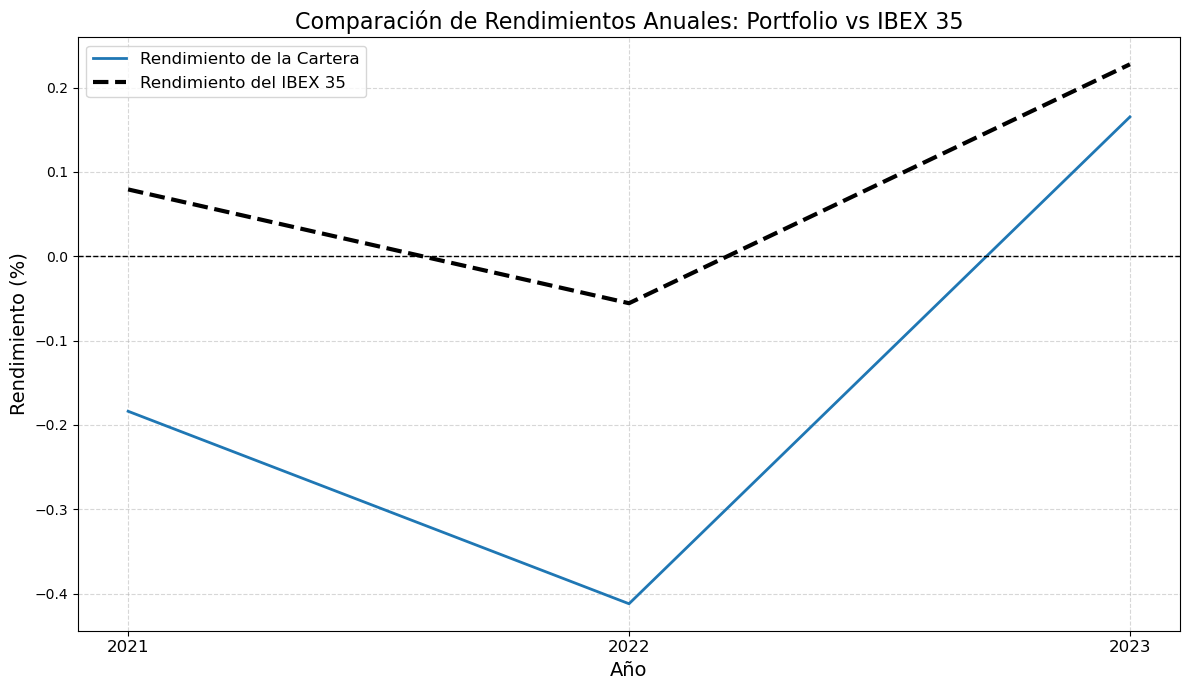

In [33]:
visualizar(resultados_mmv)

### CAPM

#### Creación del modelo

##### Cálculo de las betas

In [34]:
def betas(rendimientos_activos, rendimientos_mercado):
    'Calcula la beta de cada activo con respecto al mercado'

    # Me aseguro de que las fechas coinciden
    rendimientos_activos = rendimientos_activos.loc[rendimientos_mercado.index]
    rendimientos_mercado = rendimientos_mercado.loc[rendimientos_activos.index]

    betas = {}
    for ticker in rendimientos_activos.columns:
        # Me aseguro de que ambos arrays tienen la misma longitud
        rendimientos_activo = rendimientos_activos[ticker].values
        rendimientos_mercado_alineados = rendimientos_mercado.values.squeeze()

        # Filtro los valores válidos (aquellos que no son NaN)
        mask = ~np.isnan(rendimientos_activo) & ~np.isnan(rendimientos_mercado_alineados)
        if mask.sum() == 0:
            betas[ticker] = np.nan
            continue

        # Calculo covarianza y varianza
        cov = np.cov(rendimientos_activo[mask], rendimientos_mercado_alineados[mask])[0, 1]
        var_mercado = np.var(rendimientos_mercado_alineados[mask])

        # Calculo la beta solo si la varianza del mercado es positiva
        betas[ticker] = cov / var_mercado if var_mercado > 0 else np.nan

    return pd.Series(betas)


In [35]:
# Ejemplo con todos los datos
betas_historicas = betas(rendimientos_componentes, rendimientos_ibex)
betas_historicas

PUIG     0.753711
NTGY     0.794331
IDR      0.740241
ELE      0.656479
BKT      1.093356
           ...   
MVC      0.455983
IBR      0.724694
MAS      0.105102
ENC      0.858530
ABG.P    1.010017
Length: 69, dtype: float64

In [36]:
def betas_periodo(año_inicio, años_atras):
    'Calcula las betas de los activos que componen la cartera en la fecha inicial, usando el rango de fechas dado'

    rendimientos_activos = rendimientos_diarios_filtrados(año_inicio, años_atras)
    min_obs = int(0.8 * len(rendimientos_activos)) # Filtro para no contar con activos con pocos datos
    rendimientos_activos_relevantes = rendimientos_activos.dropna(axis=1, thresh=min_obs)

    mask_ultima_fecha = rendimientos_activos_relevantes.iloc[-1].notna() # Me aseguro de que sigan cotizando
    rendimientos_activos_relevantes = rendimientos_activos_relevantes.loc[:, mask_ultima_fecha]

    rendimientos_mercado = filtrar_rendimientos_ibex(año_inicio, años_atras)

    betas_filtradas = betas(rendimientos_activos_relevantes, rendimientos_mercado)

    return betas_filtradas

In [37]:
# Ejemplo con un periodo de tiempo específico
año_inicio = 2015
años_atras = 5

betas_filtradas = betas_periodo(año_inicio, años_atras)
betas_filtradas

ABE     0.718754
ACS     1.021453
ACX     0.787607
AMS     0.475631
ANA     1.049550
BBVA    1.314326
BKIA    0.915371
BKT     1.211599
CABK    0.950071
DIA     0.655592
ELE     0.738719
ENG     0.613684
FCC     1.129117
FER     0.730128
SGRE    1.295033
NTGY    0.847592
GRF     0.511947
IAG     0.841455
IBE     0.968694
IDR     0.827765
ITX     0.713035
MAP     1.052542
MTS     1.086515
OHLA    0.973984
POP     1.193832
RED     0.665629
REP     1.089069
SAB     1.041736
SAN     1.303675
SCYR    1.384926
TEF     0.960111
TL5     1.017514
TRE     0.735103
dtype: float64

##### Cálculo de los rendimientos esperados

In [38]:
def rendimiento_esperado_capm(betas_filtradas, año_inicio, años_atras):
    'Calcula el rendimiento esperado de cada activo, usando datos reales del risk free'

    rendimientos_mercado = filtrar_rendimientos_ibex(año_inicio, años_atras)
    rf_filtrado = filtrar_risk_free(año_inicio, años_atras)

    # Promedio del risk-free
    risk_free_real = rf_filtrado.mean().iloc[0]

    rendimientos_esperados = {}
    rendimiento_esperado_mercado = rendimientos_mercado.mean() * 252

    for ticker, beta in betas_filtradas.items():
        rendimientos_esperados[ticker] = risk_free_real + beta * (rendimiento_esperado_mercado - risk_free_real)

    rendimientos_esperados_df = pd.DataFrame(rendimientos_esperados).T

    return rendimientos_esperados_df

##### Modelo

In [39]:
def modelo_capm(rendimientos_diarios_filtrados, año_inicio, años_atras, risk_free_real):
    'Obtiene los pesos óptimos de una cartera mediante el CAPM'
    try:
        # Valido las entradas
        if rendimientos_diarios_filtrados.empty:
            raise ValueError('El DataFrame de rendimientos diarios está vacío')

        # Calculo los parámetros del CAPM y las covarianzas anualizadas
        betas_filtradas = betas_periodo(año_inicio, años_atras)
        rendimiento_esperado = rendimiento_esperado_capm(betas_filtradas, año_inicio, años_atras)
        matriz_covarianzas = rendimientos_diarios_filtrados.cov() * 252
        num_activos = len(rendimiento_esperado)

        # Límites de pesos
        limites = tuple((peso_min, peso_max) for _ in range(num_activos))

        # Restricciones de pesos
        restricciones = [
            { 'type': 'eq',
              'fun': lambda pesos: np.sum(pesos) - peso_total },
            { 'type': 'ineq',
              'fun': lambda pesos: peso_conc_max - np.sum(pesos[pesos > umbral]) }
        ]

       # Pesos iniciales: igual distribución
        pesos_iniciales = np.ones(num_activos) / num_activos

        # Optimización
        resultado = minimize(sharpe_ratio, pesos_iniciales, args=(rendimiento_esperado, matriz_covarianzas, risk_free_real),
                          method='SLSQP', bounds=limites, constraints=restricciones)

        pesos_optimos = resultado.x
        sharpe_ratio_opt = -resultado.fun

        # Calculo el rendimiento ex ante
        rendimiento_ex_ante = np.dot(pesos_optimos, rendimiento_esperado.values).item()

        # DataFrame de resultados
        pesos_tickers = pd.DataFrame({
            'Ticker': rendimientos_diarios_filtrados.columns,
            'Pesos':  np.round(pesos_optimos, 4)
        })

        return pesos_tickers, sharpe_ratio_opt, rendimiento_ex_ante

    except Exception as e:
        raise RuntimeError(f'Error al optimizar la cartera: {e}')


#### Comparación de una cartera optimizada frente al Ibex35

In [40]:
def CAPM(año_inicio, años_atras, año_final):
    'Calcula la diferencia entre el rendimiento de una cartera optimizada por el CAPM y el Ibex35'
    capm = {}
    resultados = []
    rendimiento_cartera_ex_ante = []

    for año in range(año_inicio, año_final):
        try:
            # Calculo rendimientos diarios filtrados para el año actual
            rendimientos_diarios = rendimientos_diarios_filtrados(año, años_atras)
            min_obs = int(0.8 * len(rendimientos_diarios)) # Filtro para no contar con activos con pocos datos
            rendimientos_diarios_relevantes = rendimientos_diarios.dropna(axis=1, thresh=min_obs)

            # Calculo el risk free rate para el periodo actual
            rf_filtrado = filtrar_risk_free(año, años_atras)
            risk_free_real = rf_filtrado.mean().iloc[0]

            # Optimizo la cartera para el año actual
            pesos_optimos, sharpe_ratio_opt, rendimiento_ex_ante = modelo_capm(rendimientos_diarios_relevantes, año, años_atras, risk_free_real)

            # Calculo el rendimiento de la cartera optimizada para el año siguiente
            rendimiento_cartera = rendimiento_año_siguiente(año, pesos_optimos)

            # Calculo el rendimiento del IBEX 35 para el año siguiente
            rendimiento_ibex = rendimientos_anuales_ibex(indice, [año + 1])

            # Calculo el Ratio de Sharpe de la cartera optimizada para el año siguiente
            sharpe_ex_post = sharpe_año_siguiente(año, pesos_optimos)

            resultados.append({
                'Año': año + 1,
                'Rendimiento de la Cartera': rendimiento_cartera,
                'Rendimiento del IBEX 35': rendimiento_ibex.get(año + 1, None)
            })

            # Guardo los resultados de la optimización
            capm[año] = {
                'Pesos': pesos_optimos,
                'Sharpe Ratio Ex Ante': sharpe_ratio_opt,
                'Sharpe Ratio Ex Post' : sharpe_ex_post}

            rendimiento_cartera_ex_ante.append({
                    'Año': año + 1,
                    'Rendimiento Ex Ante': rendimiento_ex_ante})

        except Exception as e:
            print(f'Error procesando el año {año}: {e}')

    # Convierto los resultados a un DataFrame para mejor visualización
    resultados_df = pd.DataFrame(resultados)
    if not resultados_df.empty:
        # Calculo la diferencia entre rendimientos
        resultados_df['Diferencia'] = resultados_df['Rendimiento de la Cartera'] - resultados_df['Rendimiento del IBEX 35']

        # Convierto los resultados a porcentaje
        for columna in ['Rendimiento de la Cartera', 'Rendimiento del IBEX 35', 'Diferencia']:
            resultados_df[columna] = resultados_df[columna].map(lambda x: f'{x * 100:.4f}%')
    else:
        print('No se generaron resultados válidos para los años seleccionados.')

    return resultados_df, capm, rendimiento_cartera_ex_ante

In [41]:
# Ejemplo
año_inicio = 2020
años_atras = 5
año_final = 2023

resultados_CAPM, detalle_CAPM, CAPM_ex_ante = CAPM(año_inicio, años_atras, año_final)
resultados_CAPM

,Año,Rendimiento de la Cartera,Rendimiento del IBEX 35,Diferencia
0,2021,29.2890%,7.9278%,21.3612%
1,2022,15.2743%,-5.5623%,20.8366%
2,2023,7.5412%,22.7613%,-15.2201%


#### Visualización

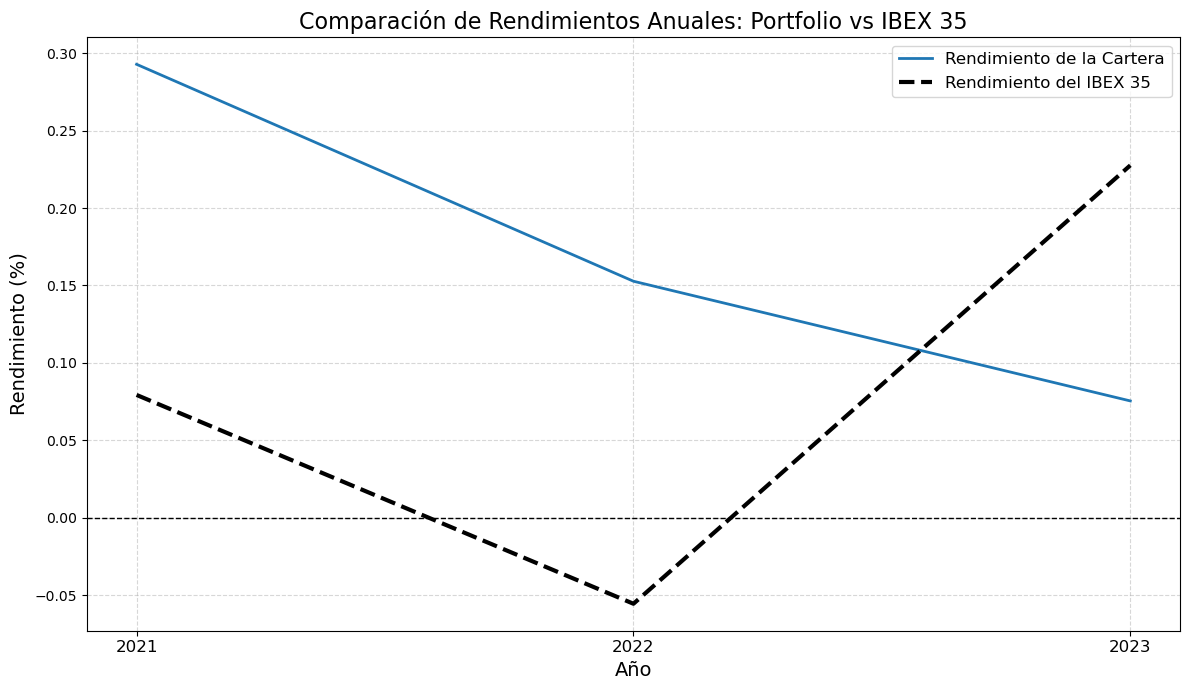

In [42]:
visualizar(resultados_CAPM)

## Enfoques Avanzados

### Volatilidad Estocástica - Modelo de Heston

#### Cálculo de métricas historicas

In [43]:
def calcular_metricas_historicas_VE(rendimiento_ibex):
    'Calcula las métricas históricas del modelo de Heston'

    # Como rendimientos_ibex es un DataFrame, uso la primera columna como Series
    if isinstance(rendimiento_ibex, pd.DataFrame):
        rendimiento_ibex = rendimiento_ibex.iloc[:, 0]

    # 1) Cálculo de la varianza diaria de cada Rendimiento
    varianza_diaria = rendimiento_ibex ** 2

    # 2) θ: varianza media a largo plazo
    theta = varianza_diaria.mean()

    # 3) Preparar la serie del cambio de varianza
    varianza_lag = varianza_diaria.shift(1).dropna()
    delta_varianza = varianza_diaria.diff().dropna()

    # 4) κ: velocidad de reversión a la media
    try:
        pendiente, intercepto, r_valor, p_valor, std_err = linregress(
            varianza_lag.loc[delta_varianza.index],
            delta_varianza)
        kappa = -pendiente                                            # κ = –pendiente de la regresión
    except Exception as e:
        print(f"Error al calcular kappa: {e}")
        kappa = np.nan

    # 5) σ: volatilidad del proceso de varianza
    try:
        sigma = delta_varianza.std()
    except Exception as e:
        print(f"Error al calcular sigma: {e}")
        sigma = np.nan

    # 6) ρ: correlación entre rendimiento y cambio de varianza
    try:
        rho = np.corrcoef(
            rendimiento_ibex.loc[delta_varianza.index],
            delta_varianza
        )[0, 1]                                                       # Extraigo el coeficiente de correlación
    except Exception as e:
        print(f"Error al calcular rho: {e}")
        rho = np.nan

    metricas = {
        'kappa': kappa,
        'theta': theta,
        'sigma': sigma,
        'rho':   rho}

    return metricas

In [44]:
# Calculo las métricas históricas
metricas_historicas = calcular_metricas_historicas_VE(rendimientos_ibex)
metricas_historicas

{'kappa': 0.8426736555251755,
 'theta': 0.00018706315318317562,
 'sigma': 0.000850760564766822,
 'rho': -0.06071480963024859}

#### Simulación de volatilidades

In [45]:
def volatilidades_heston(parametros):
    'Simula volatilidades dinámicas utilizando el modelo de Heston'

    # Extraigo los parámetros del modelo
    kappa = parametros['kappa']
    theta = parametros['theta']
    sigma = parametros['sigma']
    rho = parametros['rho']

    # Obtengo los tickers de los activos y las fechas
    tickers = rendimientos_componentes.columns
    fechas = rendimientos_componentes.index
    N = len(fechas)  # Número total de días en el conjunto de datos
    dt = 1 / 252

    # Inicializo las volatilidades
    v0 = rendimientos_componentes.var().values  # Varianza inicial basada en datos históricos
    volatilidades_simuladas = pd.DataFrame(index=fechas, columns=tickers)

    # Simulo cada activo
    for ticker in tickers:
        v = v0[tickers.get_loc(ticker)]
        volatilidades = np.zeros(N)
        volatilidades[0] = v
        for t in range(1, N):
            dW = np.random.normal()
            dv = kappa * (theta - volatilidades[t - 1]) * dt + sigma * np.sqrt(max(volatilidades[t - 1], 0)) * dW * np.sqrt(dt)
            volatilidades[t] = max(volatilidades[t - 1] + dv, 0)  # Asegura valores positivos
        volatilidades_simuladas[ticker] = np.sqrt(volatilidades)

    return volatilidades_simuladas

In [46]:
# Ejemplo de uso con parámetros históricos
volatilidades_simuladas_historicas = volatilidades_heston(metricas_historicas)
volatilidades_simuladas_historicas.head()

,PUIG,NTGY,IDR,ELE,BKT,BBVA,SCYR,ANA,REP,SAN,...,TRE,FAD,PRS,TEM,TPI,MVC,IBR,MAS,ENC,ABG.P
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-30,0.021883,0.016313,0.019280,0.015736,0.021187,0.021239,0.026896,0.020749,0.019311,0.021410,...,0.024360,0.013713,0.033850,0.012170,0.010354,0.054920,0.023045,0.028009,0.023651,0.048023
2004-01-02,0.021885,0.016289,0.019254,0.015763,0.021172,0.021210,0.026839,0.020702,0.019275,0.021376,...,0.024298,0.013678,0.033867,0.012207,0.010371,0.054811,0.023010,0.027975,0.023606,0.047957
2004-01-05,0.021859,0.016288,0.019253,0.015749,0.021148,0.021222,0.026834,0.020616,0.019265,0.021405,...,0.024262,0.013694,0.033807,0.012281,0.010369,0.054700,0.022968,0.027913,0.023572,0.047863
2004-01-07,0.021872,0.016245,0.019252,0.015705,0.021121,0.021162,0.026780,0.020636,0.019247,0.021411,...,0.024255,0.013698,0.033753,0.012277,0.010378,0.054623,0.022879,0.027903,0.023519,0.047794
2004-01-08,0.021803,0.016254,0.019254,0.015729,0.021105,0.021116,0.026683,0.020594,0.019239,0.021363,...,0.024174,0.013720,0.033695,0.012268,0.010413,0.054490,0.022879,0.027887,0.023502,0.047721


#### Cáculo de las covarianzas dinámicas

In [47]:
def covarianza_dinamica(volatilidades_simuladas, correlaciones_historicas):
    'Calcula matrices de covarianza dinámicas basadas en las volatilidades simuladas'

    tickers = volatilidades_simuladas.columns
    covarianzas_dinamicas = {}

    for fecha in volatilidades_simuladas.index:
        # Calculo las volatilidades en la fecha específica
        volat_actual = volatilidades_simuladas.loc[fecha]
        activos_validos = volat_actual > 0  # Filtra activos con volatilidad positiva

        if activos_validos.any():
            volat_actual = volat_actual[activos_validos].values
            correlaciones_validas = correlaciones_historicas[np.ix_(activos_validos, activos_validos)]

            # Matriz de covarianza
            diag_volat = np.diag(np.sqrt(volat_actual))
            covarianza = diag_volat @ correlaciones_validas @ diag_volat
            covarianza *= 252
        else:
            # Si no hay activos válidos, crea una matriz vacía
            covarianza = np.zeros((len(tickers), len(tickers)))

        # Guardo la covarianza para esta fecha
        covarianzas_dinamicas[fecha] = covarianza

    return covarianzas_dinamicas

def covarianza_dinamica_promedio(covarianzas_dinamicas, año_inicio, años_atras):
    'Calcula la matriz promedio de covarianzas para un periodo definido'

     # Obtengo la composición del IBEX al final del año inicial
    fin_de_año = f'{año_inicio}-12-31'
    tickers_fin_de_año = composicion_ibex(fin_de_año, componentes_actualizados)

    # Filtro las matrices de covarianza por fechas en el periodo
    fechas_periodo = [fecha for fecha in covarianzas_dinamicas.keys() if año_inicio - años_atras <= fecha.year <= año_inicio]
    matrices = [covarianzas_dinamicas[fecha] for fecha in fechas_periodo]

    if matrices:
        promedio = np.mean(matrices, axis=0)
        tickers_totales = volatilidades_simuladas.columns

        # Filtro la matriz promedio para incluir solo los tickers relevantes
        indices = [i for i, ticker in enumerate(tickers_totales) if ticker in tickers_fin_de_año]
        covarianza_filtrada = promedio[np.ix_(indices, indices)]

        return pd.DataFrame(covarianza_filtrada, index=tickers_fin_de_año, columns=tickers_fin_de_año)
    else:
        raise ValueError('No hay matrices de covarianza disponibles para calcular el promedio.')

In [48]:
correlaciones_historicas = rendimientos_componentes.corr()
correlaciones_historicas = np.nan_to_num(correlaciones_historicas, nan=0)
covarianzas_dinamicas = covarianza_dinamica(volatilidades_simuladas_historicas, correlaciones_historicas)

#### Simulación de las volatilidades dinámicas para un periodo

In [49]:
def volatilidades_dinamicas(parametros, rendimientos):
    'Simula volatilidades dinámicas utilizando el modelo de Heston para un periodo específico'

    # Extraigo los parámetros del modelo
    kappa = parametros['kappa']
    theta = parametros['theta']
    sigma = parametros['sigma']
    rho = parametros['rho']

    # Obtengo los tickers de los activos y las fechas
    tickers = rendimientos.columns
    fechas = rendimientos.index
    N = len(fechas)  # Número total de días en el conjunto de datos
    dt = 1 / 252

    # Inicializo las volatilidades
    v0 = rendimientos.var().values  # Varianza inicial basada en datos históricos
    volatilidades_simuladas = pd.DataFrame(index=fechas, columns=tickers)

    # Simulo cada activo
    for ticker in tickers:
        v = v0[tickers.get_loc(ticker)]
        volatilidades = np.zeros(N)
        volatilidades[0] = v
        for t in range(1, N):
            dW = np.random.normal(0, np.sqrt(dt))
            dv = kappa * (theta - volatilidades[t - 1]) * dt + sigma * np.sqrt(max(volatilidades[t - 1], 0)) * dW
            volatilidades[t] = max(volatilidades[t - 1] + dv, 0)
        volatilidades_simuladas[ticker] = volatilidades

    return volatilidades_simuladas

#### Creación del modelo

In [50]:
def modelo_VE(rendimientos_diarios_periodo, risk_free_real, covarianza):
    'Obtiene los pesos óptimos de una cartera mediante el modelo de Volatilidad Estocástica de Heston'

    try:
        # Valido las entradas
        if rendimientos_diarios_periodo.empty:
            raise ValueError('El DataFrame de rendimientos diarios está vacío.')

        # Calculo la media de los rendimientos y la matriz de covarianza
        promedio_rendimientos = rendimientos_diarios_periodo.mean() * 252
        num_activos = len(promedio_rendimientos)

         # Pesos iniciales: igual distribución
        pesos_iniciales = np.ones(num_activos) / num_activos

        # Límites de pesos
        limites = tuple((peso_min, peso_max) for _ in range(num_activos))

        # Restricciones de pesos
        restricciones = [
            # 1) Suma de pesos = 1
            { 'type': 'eq',
              'fun': lambda pesos: np.sum(pesos) - peso_total },
            # 2) Restricción de concentración
            { 'type': 'ineq',
              'fun': lambda pesos: peso_conc_max - np.sum(pesos[pesos > umbral]) }]

       # Pesos iniciales: igual distribución
        pesos_iniciales = np.ones(num_activos) / num_activos

        # Optimización
        resultado = minimize(sharpe_ratio, pesos_iniciales, args=(promedio_rendimientos, covarianza, risk_free_real),
                          method='SLSQP', bounds=limites, constraints=restricciones)

        pesos_optimos = resultado.x
        sharpe_ratio_opt = -resultado.fun

        # Calculo el rendimiento ex ante
        rendimiento_ex_ante = np.dot(pesos_optimos, promedio_rendimientos.values).item()

        # Creo un DataFrame con los tickers y sus pesos
        pesos_tickers = pd.DataFrame({
            'Ticker': rendimientos_diarios_periodo.columns,
            'Pesos': pesos_optimos
        })
        pesos_tickers['Pesos'] = pesos_tickers['Pesos'].round(4)

        return pesos_tickers, sharpe_ratio_opt, rendimiento_ex_ante

    except Exception as e:
        raise RuntimeError(f'Error al optimizar la cartera: {e}')

#### Comparación de una cartera optimizada frente al Ibex35

In [51]:
def VE(año_inicio, años_atras, año_final):
    'Calcula la diferencia entre el rendimiento de una cartera optimizada por un modelo de Volatilidad Estocástica y el Ibex35'

    ve = {}
    resultados = []
    rendimiento_cartera_ex_ante = []

    for año in range(año_inicio, año_final):
        try:
            # Fijo una semilla para reproducibilidad por año
            np.random.seed(1000 + año)

            # Calculo rendimientos diarios filtrados para el año actual
            rendimientos_diarios = rendimientos_diarios_filtrados(año, años_atras)
            min_obs = int(0.8 * len(rendimientos_diarios)) # Filtro para no contar con activos con pocos datos
            rendimientos_diarios_relevantes = rendimientos_diarios.dropna(axis=1, thresh=min_obs)

            rendimientos_ibex_periodo = (indice.loc[:f'{año}-12-31', 'Price'].pct_change().dropna())
            parametros_historicos = calcular_metricas_historicas_VE(rendimientos_ibex_periodo)

            # Promedio de simulaciones Monte Carlo para la covarianza
            n_sim = 500
            suma_cov = None
            cov_prev  = None
            for i in range(n_sim):
                vols_i = volatilidades_dinamicas(parametros_historicos, rendimientos_diarios_relevantes)
                cov_i = covarianza_dinamica(vols_i, correlaciones_historicas)
                mat_i = list(cov_i.values())
                cov_prom = np.mean(mat_i, axis=0)
                suma_cov = cov_prom if suma_cov is None else suma_cov + cov_prom

            # Matriz promedio final y regularización
            covarianza_promedio = suma_cov / n_sim

            # Calculo el risk free rate del periodo
            rf_filtrado = filtrar_risk_free(año, años_atras)
            risk_free_real = rf_filtrado.mean().iloc[0]

            # Optimizo la cartera para el año actual
            pesos_optimos, sharpe_ratio_opt, rendimiento_ex_ante = modelo_VE(rendimientos_diarios_relevantes, risk_free_real, covarianza_promedio)

            # Calculo el rendimiento de la cartera optimizada para el año siguiente
            rendimiento_cartera = rendimiento_año_siguiente(año, pesos_optimos)

            # Calculo el rendimiento del IBEX 35 para el año siguiente
            rendimiento_ibex = rendimientos_anuales_ibex(indice, [año + 1])

            # Calculo el Ratio de Sharpe de la cartera optimizada para el año siguiente
            sharpe_ex_post = sharpe_año_siguiente(año, pesos_optimos)

            resultados.append({
                'Año': año + 1,
                'Rendimiento de la Cartera': rendimiento_cartera,
                'Rendimiento del IBEX 35': rendimiento_ibex.get(año + 1, None)
            })

            # Guardo los resultados de la optimización
            ve[año] = {
                'Pesos': pesos_optimos,
                'Sharpe Ratio Ex Ante': sharpe_ratio_opt,
                'Sharpe Ratio Ex Post' : sharpe_ex_post}

            rendimiento_cartera_ex_ante.append({
                    'Año': año + 1,
                    'Rendimiento Ex Ante': rendimiento_ex_ante})

        except Exception as e:
            print(f'Error procesando el año {año}: {e}')

    # Convierto los resultados a un DataFrame para mejor visualización
    resultados_df = pd.DataFrame(resultados)
    if not resultados_df.empty:
        # Calculo la diferencia entre rendimientos
        resultados_df['Diferencia'] = resultados_df['Rendimiento de la Cartera'] - resultados_df['Rendimiento del IBEX 35']

        # Convierto los resultados a porcentaje
        for columna in ['Rendimiento de la Cartera', 'Rendimiento del IBEX 35', 'Diferencia']:
            resultados_df[columna] = resultados_df[columna].map(lambda x: f'{x * 100:.4f}%')
    else:
        print('No se generaron resultados válidos para los años seleccionados.')

    return resultados_df, ve, rendimiento_cartera_ex_ante

In [52]:
# Ejemplo
año_inicio = 2020
años_atras = 5
año_final = 2023

resultados_VE, detalle_VE, VE_ex_ante = VE(año_inicio, años_atras, año_final)
resultados_VE

,Año,Rendimiento de la Cartera,Rendimiento del IBEX 35,Diferencia
0,2021,-17.4447%,7.9278%,-25.3725%
1,2022,-33.3263%,-5.5623%,-27.7639%
2,2023,6.0291%,22.7613%,-16.7322%


#### Visualización

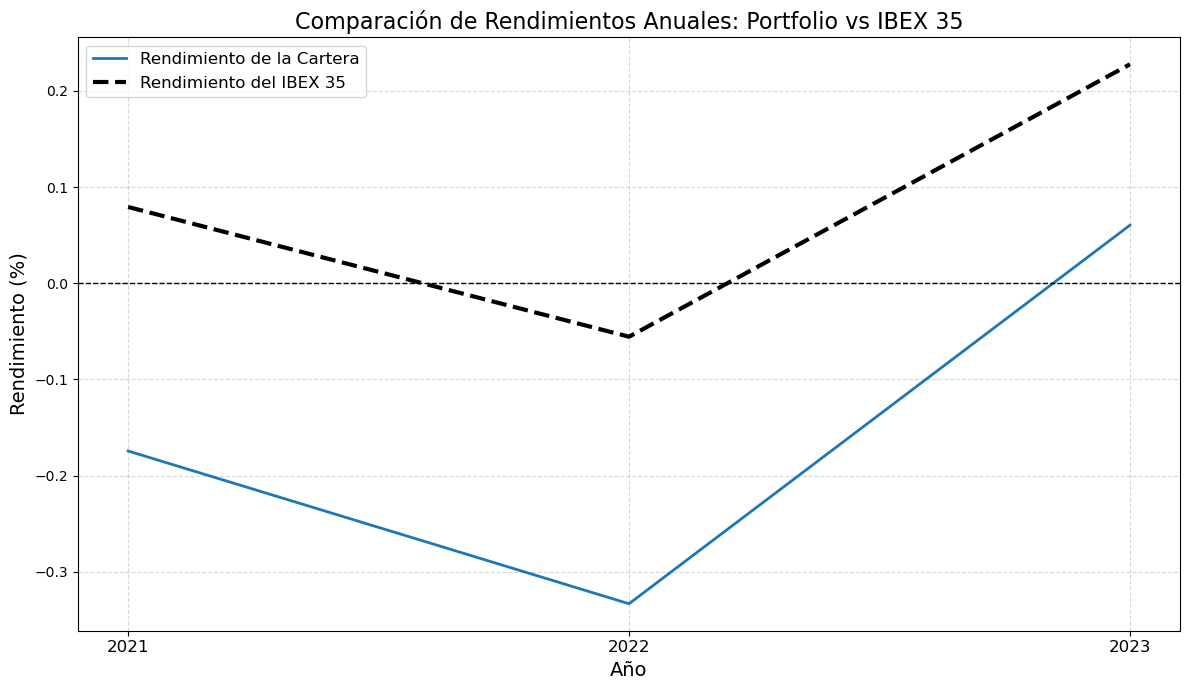

In [53]:
visualizar(resultados_VE)

### Optimización Bayesiana

#### Creación del modelo

In [54]:
def modelo_OB(rendimientos_diarios_periodo, risk_free_rate):
    'Obtiene los pesos óptimos de una cartera mediante Optimización Bayesiana'

    # Validación de entrada
    if rendimientos_diarios_periodo.empty:
        raise ValueError('El DataFrame de rendimientos diarios está vacío.')

    # Cálculo de parámetros estáticos
    promedio_rendimientos = rendimientos_diarios_periodo.mean() * 252
    matriz_covarianzas = rendimientos_diarios_periodo.cov() * 252
    tickers = rendimientos_diarios_periodo.columns.tolist()
    n_activos = len(tickers)

    # Límites de pesos
    espacio_pesos = [Real(0.0, 1.0, name=f"w{i}") for i in range(n_activos)]

    # Restricciones de pesos
    restricciones = [
            # 1) Suma de pesos = 1
            { 'type': 'eq',
              'fun': lambda pesos: np.sum(pesos) - peso_total },
            # 2) Restricción de concentración
            { 'type': 'ineq',
              'fun': lambda pesos: peso_conc_max - np.sum(pesos[pesos > umbral]) }
        ]

    # Función objetivo para gp_minimize
    @use_named_args(espacio_pesos)
    def objetivo(**pesos_dict):
        try:
            pesos = np.array(list(pesos_dict.values()))
            pesos /= np.sum(pesos)

            # Penalización de restricciones
            penalizacion = 0.0
            for r in restricciones:
                v = r["fun"](pesos)
                if r["type"] == "eq":
                    penalizacion += 1e3 * v**2
                elif v < 0:
                    penalizacion += 1e3 * v**2

            valor = sharpe_ratio(
                pesos, promedio_rendimientos, matriz_covarianzas, risk_free_rate
            ) + penalizacion

            if np.isnan(valor) or np.isinf(valor):
                print("nan/inf en la métrica; penalizo el punto")
                return 1e8                       # punto “muy malo”, no quiero abortar

            return float(valor)

        except Exception as err:
            print("Error en objetivo:", err)
            return 1e8

    # Defino el criterio de convergencia de mejora
    class ParadaSinMejora:
        def __init__(self, paciencia=100, tolerancia=1e-4):
            self.paciencia = paciencia
            self.tolerancia = tolerancia
            self.mejor = np.inf
            self.espera = 0

        def __call__(self, res):
            if res.fun < self.mejor - self.tolerancia:
                self.mejor  = res.fun
                self.espera = 0
            else:
                self.espera += 1

            # Devuelvo True solo si hay que abortar
            return self.espera >= self.paciencia

    stopper = ParadaSinMejora(paciencia=100, tolerancia=1e-4)

    # Optimización
    resultado = gp_minimize(objetivo,espacio_pesos,n_calls=400,n_initial_points=70,random_state=4,callback=[stopper],verbose=False)

    # Extraigo los pesos óptimos y los normalizo
    pesos_optimos = np.array(resultado.x)
    pesos_optimos /= np.sum(pesos_optimos)

    # Rendimiento ex ante
    rendimiento_ex_ante = np.dot(pesos_optimos, promedio_rendimientos.values).item()

    # DataFrame con resultados
    pesos_tickers = pd.DataFrame({
        'Ticker': tickers,
        'Pesos': np.round(pesos_optimos, 4)
    })

    sharpe_opt = -resultado.fun
    evol_bayesiana = resultado.func_vals

    return pesos_tickers, sharpe_opt, rendimiento_ex_ante, evol_bayesiana


def visualizar_evolucion_OB(evol_bayesiana):
    'Dibuja la evolución de la función objetivo en cada iteración'
    iters = np.arange(1, len(evol_bayesiana) + 1)
    obj_vals = np.array(evol_bayesiana)
    best_so_far = np.minimum.accumulate(obj_vals)

    plt.figure()
    plt.plot(iters, obj_vals, label='valor observado')
    plt.plot(iters, best_so_far, label='mejor hasta ahora', linewidth=2)
    plt.xlabel('iteración')
    plt.ylabel('valor objetivo (–Sharpe)')
    plt.title('Evolución de Optimización Bayesiana')
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Comparación de una cartera optimizada frente al Ibex35

In [55]:
def OB(año_inicio, años_atras, año_final):
    'Calcula la diferencia entre el rendimiento de una cartera optimizada por un modelo de Optimizacion Bayesiana y el Ibex35'

    ob = {}
    resultados = []
    rendimiento_cartera_ex_ante = []
    evolucion_optimizacion = {}

    for año in range(año_inicio, año_final):
        try:
            # Calculo rendimientos diarios filtrados para el año actual
            rendimientos_diarios = rendimientos_diarios_filtrados(año, años_atras)
            min_obs = int(0.8 * len(rendimientos_diarios)) # Filtro para no contar con activos con pocos datos
            rendimientos_diarios_relevantes = rendimientos_diarios.dropna(axis=1, thresh=min_obs)

            # Calculo el risk free rate del periodo
            rf_filtrado = filtrar_risk_free(año, años_atras)
            risk_free_real = rf_filtrado.mean().iloc[0]

            # Optimizo la cartera para el año actual
            pesos_optimos, sharpe_ratio_opt, rendimiento_ex_ante, evolucion_bayesiana = modelo_OB(rendimientos_diarios_relevantes, risk_free_real)

            # Calculo el rendimiento de la cartera optimizada para el año siguiente
            rendimiento_cartera = rendimiento_año_siguiente(año, pesos_optimos)

            # Calculo el rendimiento del IBEX 35 para el año siguiente
            rendimiento_ibex = rendimientos_anuales_ibex(indice, [año + 1])

            # Calculo el Ratio de Sharpe de la cartera optimizada para el año siguiente
            sharpe_ex_post = sharpe_año_siguiente(año, pesos_optimos)

            resultados.append({
                'Año': año + 1,
                'Rendimiento de la Cartera': rendimiento_cartera,
                'Rendimiento del IBEX 35': rendimiento_ibex.get(año + 1, None)
            })

            # Guardo los resultados de la optimización
            ob[año] = {
                'Pesos': pesos_optimos,
                'Sharpe Ratio Ex Ante': sharpe_ratio_opt,
                'Sharpe Ratio Ex Post' : sharpe_ex_post}

            rendimiento_cartera_ex_ante.append({
                    'Año': año + 1,
                    'Rendimiento Ex Ante': rendimiento_ex_ante})

            # Guardo la evolución de la optimización
            evolucion_optimizacion[año + 1] = evolucion_bayesiana

        except Exception as e:
            print(f'Error procesando el año {año}: {e}')

    # Convierto los resultados a un DataFrame para mejor visualización
    resultados_df = pd.DataFrame(resultados)
    if not resultados_df.empty:
        # Calculo la diferencia entre rendimientos
        resultados_df['Diferencia'] = resultados_df['Rendimiento de la Cartera'] - resultados_df['Rendimiento del IBEX 35']

        # Convierto los resultados a porcentaje
        for columna in ['Rendimiento de la Cartera', 'Rendimiento del IBEX 35', 'Diferencia']:
            resultados_df[columna] = resultados_df[columna].map(lambda x: f'{x * 100:.4f}%')
    else:
        print('No se generaron resultados válidos para los años seleccionados.')

    return resultados_df, ob, rendimiento_cartera_ex_ante, evolucion_optimizacion

In [56]:
# Ejemplo de uso
año_inicio = 2020
años_atras = 5
año_final = 2023

resultados_OB, detalle_OB, OB_ex_ante, evol_optimizacion = OB(año_inicio, años_atras, año_final)
resultados_OB

,Año,Rendimiento de la Cartera,Rendimiento del IBEX 35,Diferencia
0,2021,-2.6259%,7.9278%,-10.5537%
1,2022,-23.4758%,-5.5623%,-17.9134%
2,2023,13.8612%,22.7613%,-8.9001%


#### Visualización

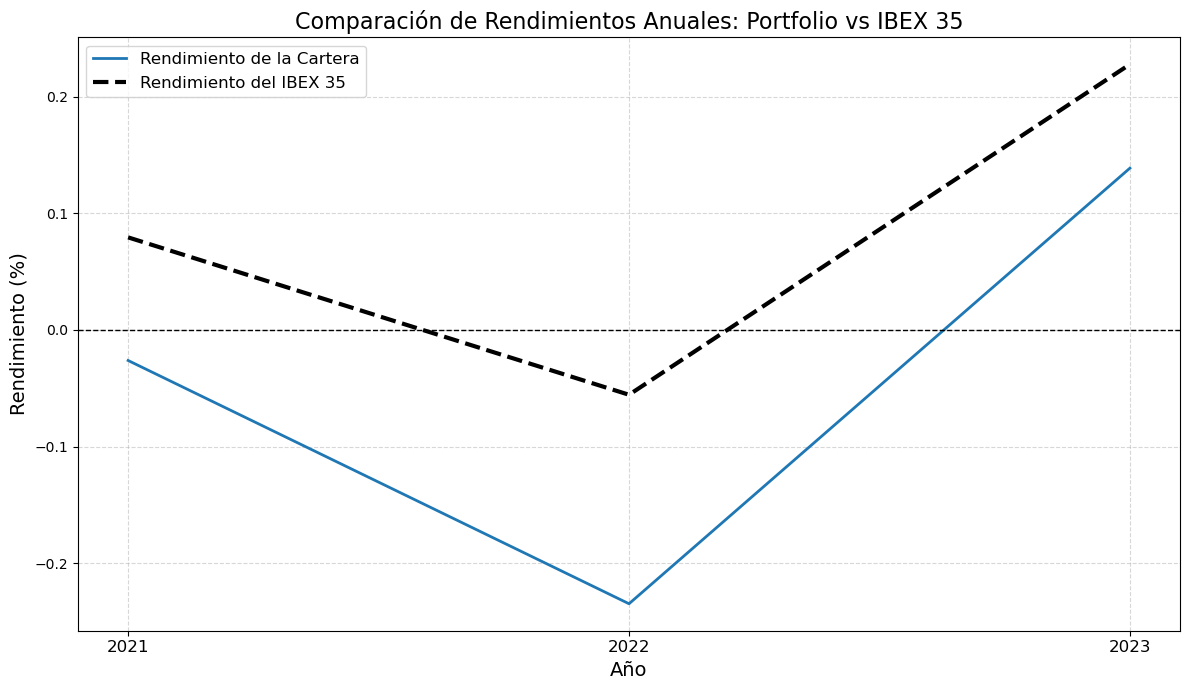

In [57]:
visualizar(resultados_OB)

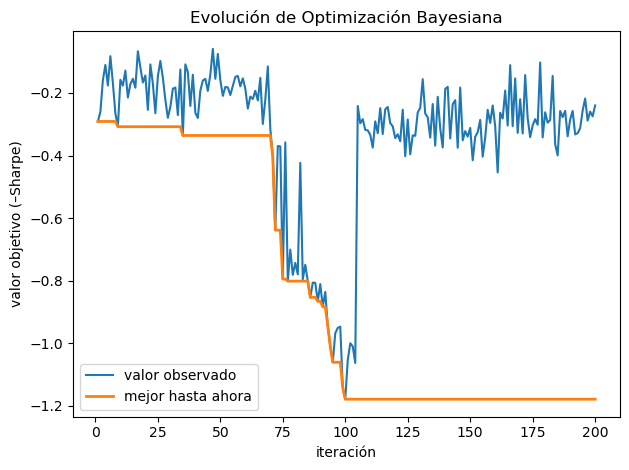

In [58]:
visualizar_evolucion_OB(evol_optimizacion[2023])

## Comparativa de Escenarios

### Modelo de comparacion

In [59]:
def comparativa_modelos(año_inicio, años_atras, año_final):
    'Obtiene y compara los resultados de todos los métodos dado un escenario'

    resultados_ex_ante = []
    resultados_ex_post = []
    resultados_dif = []
    rendimientos_list = []
    pesos = {}

    for año in range(año_inicio, año_final):
        año_siguiente = año + 1
        try:
            # Ejecuto todos los métodos
            resultados_MMV, detalles_MMV, ex_ante_MMV = MMV(año, años_atras, año_siguiente)
            resultados_CAPM, detalles_CAPM, ex_ante_CAPM = CAPM(año, años_atras, año_siguiente)
            resultados_VE, detalles_VE, ex_ante_VE = VE(año, años_atras, año_siguiente)
            resultados_OB, detalles_OB, ex_ante_OB, evol = OB(año, años_atras, año_siguiente)

            rend_IBEX = rendimientos_anuales_ibex(indice, [año_siguiente])
            rentabilidad_IBEX = rend_IBEX.get(año_siguiente, None)

            # Alfas (ahora como float, no string)
            alfa_MMV = float(resultados_MMV.loc[0, 'Diferencia'].strip('%'))
            alfa_CAPM = float(resultados_CAPM.loc[0, 'Diferencia'].strip('%'))
            alfa_ve = float(resultados_VE.loc[0, 'Diferencia'].strip('%'))
            alfa_ob = float(resultados_OB.loc[0, 'Diferencia'].strip('%'))

            # Ratios de Sharpe
            Sharpe_Ante_MMV, Sharpe_Post_MMV = extraer_sharpe(detalles_MMV).loc[año, ['Sharpe Ratio Ex Ante', 'Sharpe Ratio Ex Post']]
            Sharpe_Ante_CAPM, Sharpe_Post_CAPM = extraer_sharpe(detalles_CAPM).loc[año, ['Sharpe Ratio Ex Ante', 'Sharpe Ratio Ex Post']]
            Sharpe_Ante_VE, Sharpe_Post_VE = extraer_sharpe(detalles_VE).loc[año, ['Sharpe Ratio Ex Ante', 'Sharpe Ratio Ex Post']]
            Sharpe_Ante_OB, Sharpe_Post_OB = extraer_sharpe(detalles_OB).loc[año, ['Sharpe Ratio Ex Ante', 'Sharpe Ratio Ex Post']]

            # Rendimientos esperados
            Rendimientos_Ex_Ante_MMV = ex_ante_MMV[0]['Rendimiento Ex Ante']
            Rendimientos_Ex_Ante_CAPM = ex_ante_CAPM[0]['Rendimiento Ex Ante']
            Rendimientos_Ex_Ante_VE = ex_ante_VE[0]['Rendimiento Ex Ante']
            Rendimientos_Ex_Ante_OB = ex_ante_OB[0]['Rendimiento Ex Ante']

            # Rendimientos reales
            pesos_MMV = detalles_MMV[año]['Pesos']
            pesos_CAPM = detalles_CAPM[año]['Pesos']
            pesos_VE = detalles_VE[año]['Pesos']
            pesos_OB = detalles_OB[año]['Pesos']
            Rendimientos_Reales_MMV = rendimiento_año_siguiente(año, pesos_MMV)
            Rendimientos_Reales_CAPM = rendimiento_año_siguiente(año, pesos_CAPM)
            Rendimientos_Reales_VE = rendimiento_año_siguiente(año, pesos_VE)
            Rendimientos_Reales_OB = rendimiento_año_siguiente(año, pesos_OB)

            # Guardo todos los resultados ex-ante
            resultados_ex_ante.append({
                ('MMV', 'Rendimiento Esperado'): f"{Rendimientos_Ex_Ante_MMV * 100:.4f}%",
                ('MMV', 'Sharpe Ex Ante'): Sharpe_Ante_MMV,
                ('CAPM', 'Rendimiento Esperado'): f"{Rendimientos_Ex_Ante_CAPM * 100:.4f}%",
                ('CAPM', 'Sharpe Ex Ante'): Sharpe_Ante_CAPM,
                ('VE', 'Rendimiento Esperado'): f"{Rendimientos_Ex_Ante_VE * 100:.4f}%",
                ('VE', 'Sharpe Ex Ante'): Sharpe_Ante_VE,
                ('OB', 'Rendimiento Esperado'): f"{Rendimientos_Ex_Ante_OB * 100:.4f}%",
                ('OB', 'Sharpe Ex Ante'): Sharpe_Ante_OB,
                'Año': año_siguiente
            })

            # Guardo todos los resultados ex-post
            resultados_ex_post.append({
                ('MMV', 'Rendimiento Real'): f"{Rendimientos_Reales_MMV * 100:.4f}%",
                ('MMV', 'Sharpe Ex Post'): Sharpe_Post_MMV,
                ('CAPM', 'Rendimiento Real'): f"{Rendimientos_Reales_CAPM * 100:.4f}%",
                ('CAPM', 'Sharpe Ex Post'): Sharpe_Post_CAPM,
                ('VE', 'Rendimiento Real'): f"{Rendimientos_Reales_VE * 100:.4f}%",
                ('VE', 'Sharpe Ex Post'): Sharpe_Post_VE,
                ('OB', 'Rendimiento Real'): f"{Rendimientos_Reales_OB * 100:.4f}%",
                ('OB', 'Sharpe Ex Post'): Sharpe_Post_OB,
                'Año': año_siguiente
            })

            # Guardo todas las diferencias, Alfa ahora float
            resultados_dif.append({
                ('MMV', 'Alfa'): alfa_MMV,
                ('MMV', 'Δ Sharpe'): round(Sharpe_Post_MMV - Sharpe_Ante_MMV, 6),
                ('CAPM', 'Alfa'): alfa_CAPM,
                ('CAPM', 'Δ Sharpe'): round(Sharpe_Post_CAPM - Sharpe_Ante_CAPM, 6),
                ('VE', 'Alfa'): alfa_ve,
                ('VE', 'Δ Sharpe'): round(Sharpe_Post_VE - Sharpe_Ante_VE, 6),
                ('OB', 'Alfa'): alfa_ob,
                ('OB', 'Δ Sharpe'): round(Sharpe_Post_OB - Sharpe_Ante_OB, 6),
                'Año': año_siguiente
            })

            # Rendimientos para evolución de capital
            rendimientos_list.append({
                'Año': año_siguiente,
                'Media-Varianza': Rendimientos_Reales_MMV,
                'CAPM': Rendimientos_Reales_CAPM,
                'Volatilidad Estocástica': Rendimientos_Reales_VE,
                'Optimización Bayesiana': Rendimientos_Reales_OB,
                'IBEX 35': f"{rentabilidad_IBEX*100:.4f}%" if rentabilidad_IBEX is not None else None
            })

            pesos[año_siguiente] = {
                'MMV': detalles_MMV,
                'CAPM': detalles_CAPM,
                'VE': detalles_VE,
                'OB': detalles_OB
            }

        except Exception as e:
            print(f'Error en el año {año}: {e}')

    # Transformo a DataFrames
    df_ex_ante = pd.DataFrame(resultados_ex_ante).set_index('Año')
    df_ex_post = pd.DataFrame(resultados_ex_post).set_index('Año')
    df_comparativa = pd.DataFrame(resultados_dif).set_index('Año')

    df_ex_ante.columns = pd.MultiIndex.from_tuples(df_ex_ante.columns)
    df_ex_post.columns = pd.MultiIndex.from_tuples(df_ex_post.columns)
    df_comparativa.columns = pd.MultiIndex.from_tuples(df_comparativa.columns)

    df_ex_ante.index.name = 'Año'
    df_ex_post.index.name = 'Año'
    df_comparativa.index.name = 'Año'

    # Rendimientos
    df_rendimientos = (
        pd.DataFrame(rendimientos_list)
          .set_index('Año')
          .apply(lambda col: col.map(lambda x: f"{x*100:.4f}%" if isinstance(x, (int, float)) else x))
    )

    # Evolución de capital con reinversión
    df_clean = pd.DataFrame(rendimientos_list).set_index('Año')
    df_evolucion = df_clean.apply(lambda col: col.map(
        lambda x: float(x) if isinstance(x, (int, float)) else float(x.strip('%')) / 100))

    primer_año = df_evolucion.index.min()
    año_arranque = primer_año - 1
    df_inicio = pd.DataFrame(
        [[0.0] * df_evolucion.shape[1]],
        index=[año_arranque],
        columns=df_evolucion.columns
    )
    df_evolucion = pd.concat([df_inicio, df_evolucion]).sort_index()
    df_evolucion = (1 + df_evolucion).cumprod() * 100
    df_evolucion = df_evolucion.round(2)

    # Añado el promedio a df_comparativa
    promedio = df_comparativa.mean(numeric_only=True)
    promedio.name = 'Promedio'
    df_comparativa = pd.concat([df_comparativa, promedio.to_frame().T])

    # Formateo la columna Alfa como porcentaje
    for modelo in ['MMV', 'CAPM', 'VE', 'OB']:
        df_comparativa[(modelo, 'Alfa')] = df_comparativa[(modelo, 'Alfa')]\
            .map(lambda x: f"{x:.2f}%")

    return df_ex_ante, df_ex_post, df_comparativa, df_rendimientos, pesos, df_evolucion

### Escenario 1 -> Sin restricciones

In [60]:
# Límites de los pesos de cada activo
peso_min = 0   # Peso mínimo permitido por activo
peso_max = 1   # Peso máximo permitido por activo

peso_conc_max = 1 # Peso máximo permitido de concentración
umbral = 1 # Umbral de peso a partir del cual se mide la concentración

# Restricción sobre la suma de los pesos
peso_total = 1

# Parámetros
año_inicio = 2010
años_atras = 5  # Años históricos para optimizar la cartera
año_final = 2023

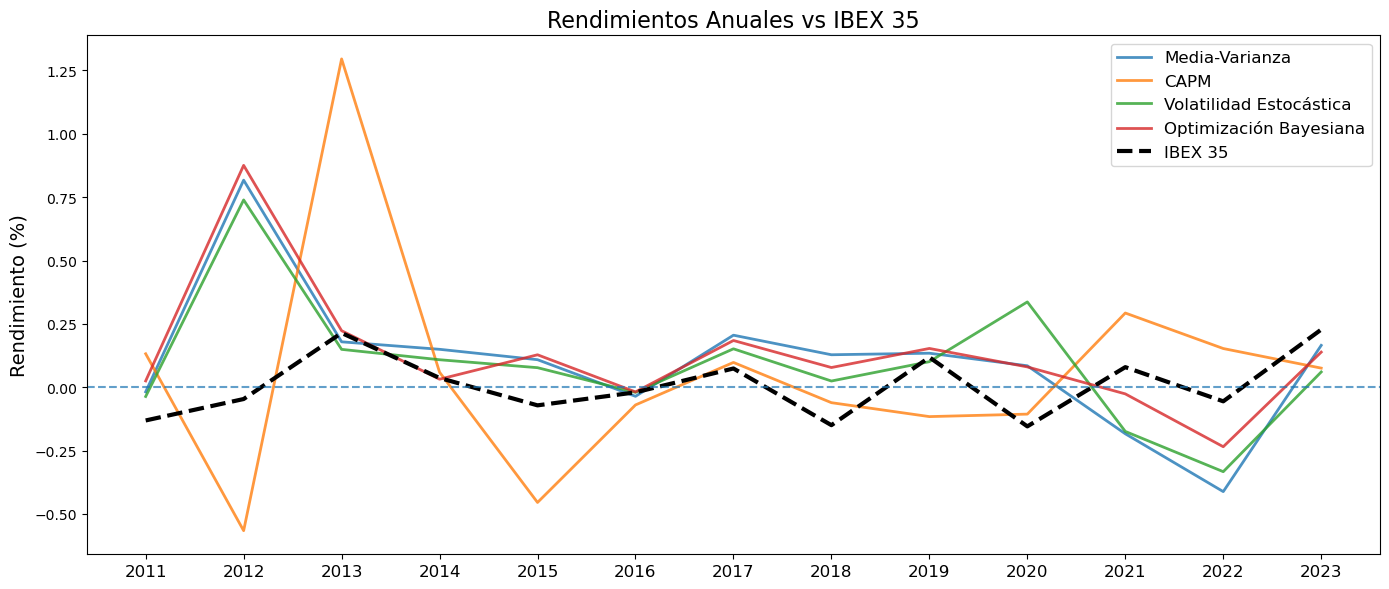

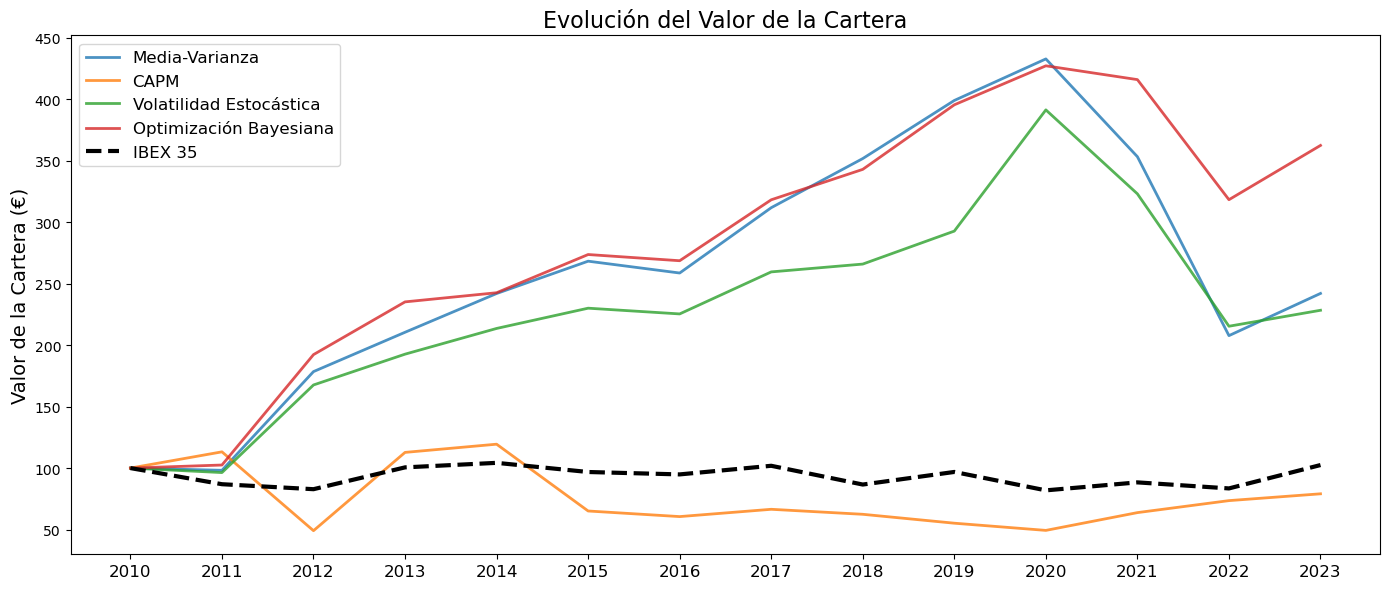

MMV               CAPM                 VE                 OB  \
             Alfa  Δ Sharpe     Alfa  Δ Sharpe     Alfa  Δ Sharpe     Alfa   
2011       11.30% -1.538671   26.31%  3.000565    9.46% -2.625179   15.60%   
2012       86.37%  2.147704  -51.96% -0.693642   78.57%  1.748898   92.21%   
2013       -3.50%  0.096964  108.14%  2.252829   -6.47% -0.156198    0.89%   
2014       11.31% -0.579833    2.26%  0.252267    7.19% -1.113341   -0.50%   
2015       18.02% -0.179164  -38.32% -0.511622   14.87% -0.322860   19.96%   
2016       -1.57% -1.390876   -4.98%  0.060177   -0.01% -1.548735    0.17%   
2017       13.14%  1.768836    2.39%  1.335930    7.76%  0.614370   11.05%   
2018       27.79% -0.142364    8.88% -0.973216   17.42% -1.572984   22.75%   
2019        1.61% -0.299069  -23.41% -0.004171   -1.73% -0.549231    3.49%   
2020       23.92% -0.825825    4.84%  0.067457   49.12% -0.321237   23.47%   
2021      -26.30% -3.492641   21.36%  2.101603  -25.37% -3.924555  -10.55%   
2022      -35.63% -3.791747   20.84%  0.491903  -27.76% -4.044128  -17.91%   
2023       -6.24% -0.532914  -15.22%  0.321137  -16.73% -1.621483   -8.90%   
Promedio    9.25% -0.673815    4.70%  0.592401    8.18% -1.187436   11.67%   

                    
          Δ Sharpe  
2011      0.106644  
2012      2.358651  
2013      0.765504  
2014     -1.175070  
2015     -0.122634  
2016     -0.892126  
2017      1.697141  
2018     -0.420508  
2019      0.029831  
2020     -0.683373  
2021     -1.562876  
2022     -2.612143  
2023     -0.587464  
Promedio -0.238340

In [61]:
Ex_ante_1, Ex_post_1, Diferencias_1, Rendimientos_1, Pesos_1, Evolucion_1 = comparativa_modelos(año_inicio, años_atras, año_final)
visualizar_escenarios(Rendimientos_1, Evolucion_1)
Diferencias_1

In [62]:
Ex_ante_1

MMV                                CAPM                 \
     Rendimiento Esperado Sharpe Ex Ante Rendimiento Esperado Sharpe Ex Ante   
Año                                                                            
2011             25.3222%       0.721643              3.0110%      -0.032340   
2012             13.3241%       0.322396             -6.8291%      -0.211355   
2013             21.6365%       0.612828             -9.5284%      -0.241353   
2014             30.9029%       1.376748              4.9298%       0.004241   
2015             28.3188%       1.214277             -0.1805%      -0.090125   
2016             28.6545%       1.234916              2.2506%      -0.014777   
2017             29.0553%       1.286528              4.3265%       0.047354   
2018             31.7623%       1.457109              6.0710%       0.184781   
2019             23.6423%       1.076434             -1.7651%      -0.082366   
2020             21.1041%       1.223456              0.0805%      -0.032248   
2021             53.6729%       1.639106             -0.6753%      -0.027617   
2022             46.8937%       2.096926              0.6215%      -0.004013   
2023             36.9232%       1.210705             -1.5704%      -0.043905   

                       VE                                  OB                 
     Rendimiento Esperado Sharpe Ex Ante Rendimiento Esperado Sharpe Ex Ante  
Año                                                                           
2011             25.1976%       1.100477             21.1980%       0.571288  
2012             13.6830%       0.369231             13.0487%       0.317234  
2013             22.4038%       0.720568             11.7371%       0.239729  
2014             32.4926%       1.634555             30.9120%       1.282511  
2015             30.6672%       1.311423             27.1539%       1.194919  
2016             28.8542%       1.504685             20.7477%       0.824442  
2017             33.0567%       1.679102             28.2263%       1.176175  
2018             37.5706%       1.805882             32.1546%       1.293757  
2019             25.2166%       1.155039             19.2881%       0.862259  
2020             22.2035%       1.327350             19.8941%       1.071990  
2021             65.6554%       2.627200             36.3485%       1.307826  
2022             52.3142%       2.820249             42.3857%       1.694211  
2023             55.9760%       1.846649             31.6201%       1.178320

In [63]:
Ex_post_1

MMV                            CAPM                 \
     Rendimiento Real Sharpe Ex Post Rendimiento Real Sharpe Ex Post   
Año                                                                    
2011         -1.8099%      -0.817028         13.2021%       2.968225   
2012         81.7170%       2.470101        -56.6133%      -0.904996   
2013         17.9204%       0.709792        129.5620%       2.011475   
2014         14.9646%       0.796914          5.9203%       0.256509   
2015         10.8677%       1.035113        -45.4685%      -0.601747   
2016         -3.5858%      -0.155960         -6.9923%       0.045400   
2017         20.5380%       3.055364          9.7837%       1.383284   
2018         12.8168%       1.314745         -6.0955%      -0.788435   
2019         13.4258%       0.777366        -11.5916%      -0.086537   
2020          8.4684%       0.397631        -10.6108%       0.035209   
2021        -18.3725%      -1.853535         29.2890%       2.073987   
2022        -41.1927%      -1.694820         15.2743%       0.487891   
2023         16.5258%       0.677791          7.5412%       0.277232   

                   VE                              OB                 
     Rendimiento Real Sharpe Ex Post Rendimiento Real Sharpe Ex Post  
Año                                                                   
2011         -3.6529%      -1.524702          2.4923%       0.677932  
2012         73.9129%       2.118128         87.5573%       2.675885  
2013         14.9428%       0.564371         22.3026%       1.005232  
2014         10.8500%       0.521214          3.1604%       0.107441  
2015          7.7146%       0.988563         12.8052%       1.072285  
2016         -2.0225%      -0.044050         -1.8435%      -0.067684  
2017         15.1575%       2.293472         18.4456%       2.873316  
2018          2.4509%       0.232898          7.7768%       0.873249  
2019         10.0868%       0.605807         15.3043%       0.892090  
2020         33.6653%       1.006112          8.0185%       0.388617  
2021        -17.4447%      -1.297355         -2.6259%      -0.255050  
2022        -33.3263%      -1.223879        -23.4758%      -0.917933  
2023          6.0291%       0.225166         13.8612%       0.590856

### Escenario 2 -> UCITS 5/10/40

In [64]:
# Límites de los pesos de cada activo
peso_min = 0   # Peso mínimo permitido por activo
peso_max = 0.1   # Peso máximo permitido por activo

peso_conc_max = 0.4 # Peso máximo permitido de concentración
umbral = 0.05 # Umbral de peso a partir del cual se mide la concentración

# Restricción sobre la suma de los pesos
peso_total = 1

# Parámetros
año_inicio = 2010
años_atras = 5  # Años históricos para optimizar la cartera
año_final = 2023

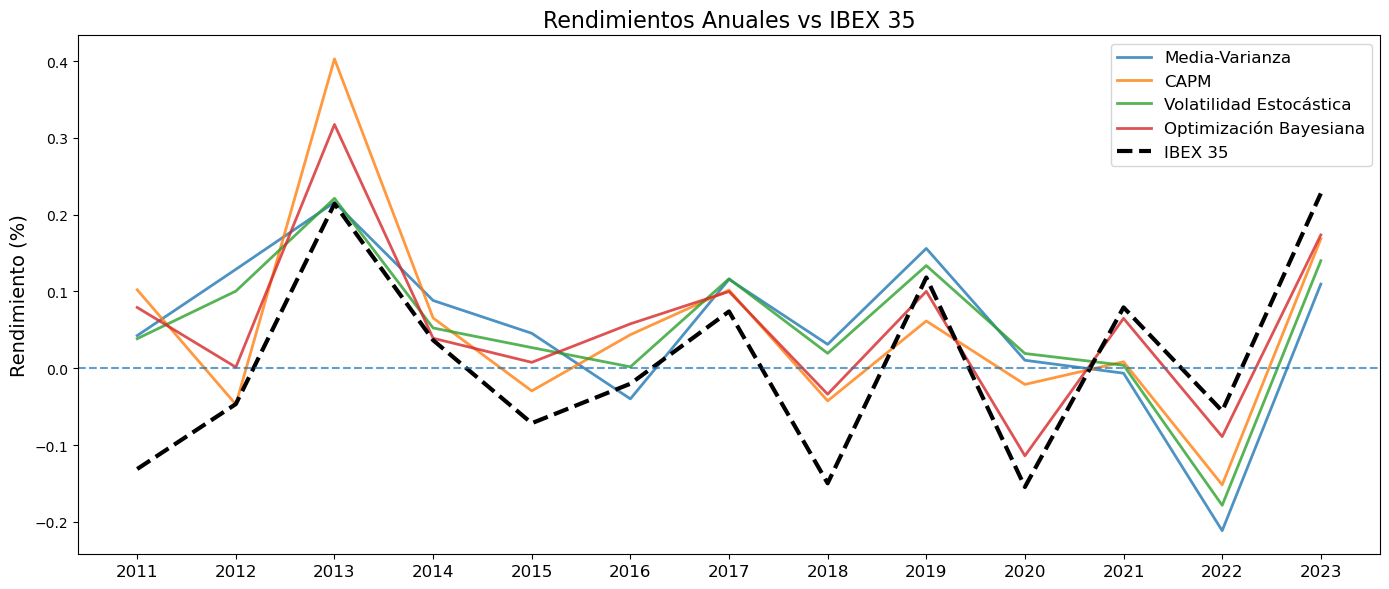

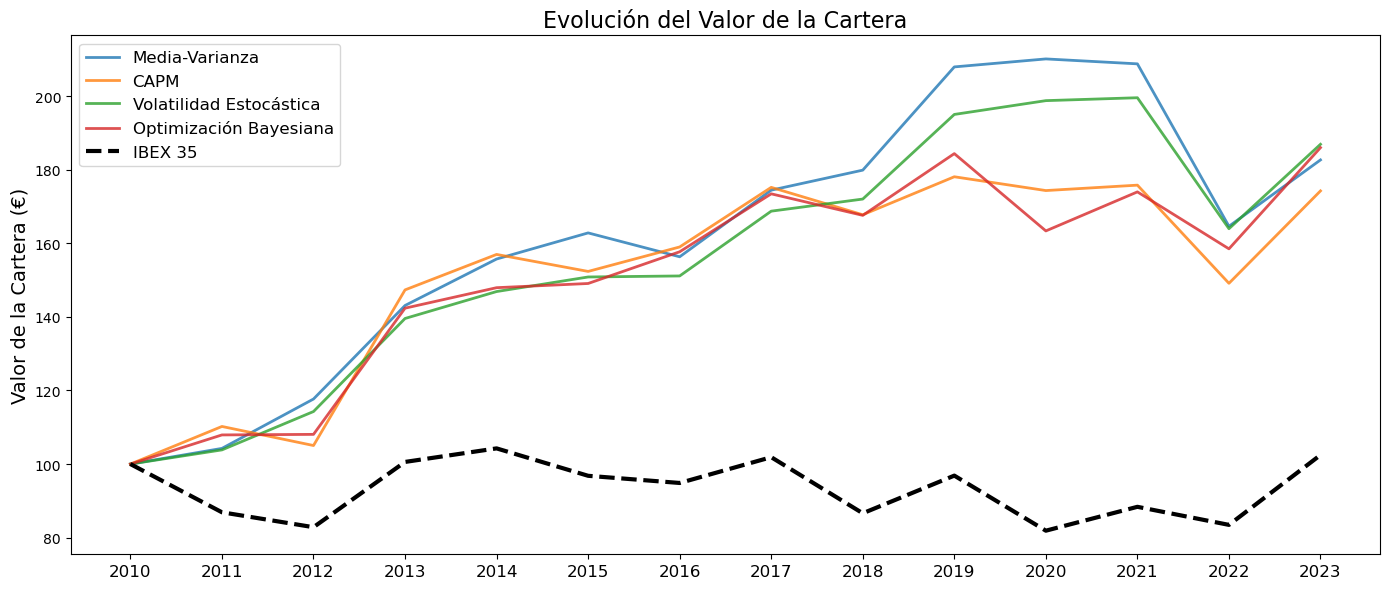

MMV              CAPM                 VE                OB  \
             Alfa  Δ Sharpe    Alfa  Δ Sharpe     Alfa  Δ Sharpe    Alfa   
2011       17.37%  1.086609  23.33%  3.405360   16.96%  0.619937  21.03%   
2012       17.54%  0.386783  -0.05%  0.014262   14.70%  0.312094   4.80%   
2013        0.18%  1.033564  18.86%  1.948662    0.71%  1.084614  10.32%   
2014        5.17% -0.472553   2.89%  0.284853    1.59% -0.859660   0.25%   
2015       11.71% -0.312058   4.21% -0.016177    9.85% -0.627389   7.92%   
2016       -1.97% -1.037692   6.38%  0.307893    2.20% -1.059422   7.80%   
2017        4.19%  1.195471   2.78%  1.483159    4.26%  0.860968   2.59%   
2018       18.09% -0.714368  10.73% -0.775282   16.92% -1.081571  11.60%   
2019        3.78%  0.446486  -5.66%  0.518369    1.55%  0.108745  -1.81%   
2020       16.49% -0.773386  13.35%  0.146894   17.37% -0.842084   4.06%   
2021       -8.57% -1.131843  -7.08%  0.353526   -7.53% -1.327348  -1.43%   
2022      -15.58% -2.497539  -9.61% -0.733405  -12.28% -2.644885  -3.33%   
2023      -11.81% -0.234933  -5.92%  0.991076   -8.77% -0.214579  -5.40%   
Promedio    4.35% -0.232728   4.17%  0.609938    4.43% -0.436198   4.49%   

                    
          Δ Sharpe  
2011      2.155518  
2012      0.163803  
2013      1.708631  
2014     -0.242187  
2015     -0.100649  
2016      0.014470  
2017      1.070021  
2018     -1.217582  
2019      0.361798  
2020     -0.604641  
2021      1.145587  
2022     -1.133746  
2023      0.625432  
Promedio  0.303573

In [65]:
Ex_ante_2, Ex_post_2, Diferencias_2, Rendimientos_2, Pesos_2, Evolucion_2 = comparativa_modelos(año_inicio, años_atras, año_final)
visualizar_escenarios(Rendimientos_2, Evolucion_2)
Diferencias_2

In [66]:
Ex_ante_2

MMV                                CAPM                 \
     Rendimiento Esperado Sharpe Ex Ante Rendimiento Esperado Sharpe Ex Ante   
Año                                                                            
2011             14.1067%       0.415264              2.2142%      -0.075523   
2012              4.6495%       0.007025             -3.7707%      -0.313524   
2013              4.2892%      -0.017800             -6.1272%      -0.365079   
2014             22.3800%       0.918590              4.9200%       0.004208   
2015             17.6565%       0.681475              0.6851%      -0.153362   
2016             21.0898%       0.872856              2.4263%      -0.068218   
2017             22.3744%       1.019050              4.2603%       0.047165   
2018             21.2780%       1.094262              5.9212%       0.184253   
2019             14.6166%       0.781029             -0.6977%      -0.130196   
2020             15.7172%       0.949704              0.4187%      -0.056105   
2021             23.2362%       1.075118             -0.3623%      -0.074007   
2022             27.2193%       1.463455              0.6433%      -0.012063   
2023             16.8174%       0.823706             -0.9082%      -0.104030   

                       VE                                  OB                 
     Rendimiento Esperado Sharpe Ex Ante Rendimiento Esperado Sharpe Ex Ante  
Año                                                                           
2011             14.9463%       0.664697              5.5342%       0.054352  
2012              3.8161%      -0.037638             -2.2818%      -0.277604  
2013              3.9654%      -0.046036             -5.3354%      -0.350905  
2014             21.6912%       1.083491             14.3696%       0.393300  
2015             17.4361%       0.835408              8.2250%       0.161988  
2016             20.5061%       1.099693             10.2628%       0.283622  
2017             22.1833%       1.303736             13.9546%       0.506684  
2018             21.4027%       1.290582             14.2193%       0.670147  
2019             15.1150%       0.885717              8.1671%       0.369573  
2020             15.8966%       1.052950              9.0829%       0.458016  
2021             24.3194%       1.501343             10.5255%       0.453379  
2022             27.6306%       1.778086             14.5056%       0.685095  
2023             17.1662%       1.014285              8.0714%       0.335952

In [67]:
Ex_post_2

MMV                            CAPM                 \
     Rendimiento Real Sharpe Ex Post Rendimiento Real Sharpe Ex Post   
Año                                                                    
2011          4.2557%       1.501873         10.2208%       3.329837   
2012         12.8803%       0.393808         -4.7049%      -0.299262   
2013         21.6004%       1.015764         40.2734%       1.583582   
2014          8.8247%       0.446038          6.5437%       0.289061   
2015          4.5565%       0.369417         -2.9437%      -0.169539   
2016         -3.9838%      -0.164836          4.3701%       0.239676   
2017         11.5827%       2.214521         10.1820%       1.530324   
2018          3.1161%       0.379893         -4.2469%      -0.591029   
2019         15.6021%       1.227515          6.1552%       0.388173   
2020          1.0432%       0.176317         -2.1045%       0.090789   
2021         -0.6409%      -0.056725          0.8437%       0.279519   
2022        -21.1442%      -1.034084        -15.1753%      -0.745468   
2023         10.9553%       0.588773         16.8433%       0.887046   

                   VE                              OB                 
     Rendimiento Real Sharpe Ex Post Rendimiento Real Sharpe Ex Post  
Año                                                                   
2011          3.8518%       1.284634          7.9173%       2.209869  
2012         10.0439%       0.274457          0.1441%      -0.113800  
2013         22.1266%       1.038579         31.7390%       1.357726  
2014          5.2445%       0.223831          3.9080%       0.151113  
2015          2.6938%       0.208019          0.7716%       0.061338  
2016          0.1876%       0.040271          5.7839%       0.298091  
2017         11.6548%       2.164704          9.9876%       1.576705  
2018          1.9489%       0.209010         -3.3758%      -0.547436  
2019         13.3683%       0.994462         10.0124%       0.731371  
2020          1.9230%       0.210866        -11.3955%      -0.146626  
2021          0.3971%       0.173995          6.4959%       1.598967  
2022        -17.8375%      -0.866799         -8.8967%      -0.448652  
2023         13.9945%       0.799706         17.3585%       0.961385

### Escenario 3 -> RIC 25/50

In [68]:
# Límites de los pesos de cada activo
peso_min = 0   # Peso mínimo permitido por activo
peso_max = 0.25   # Peso máximo permitido por activo

peso_conc_max = 0.5 # Peso máximo permitido de concentración
umbral = 0.05 # Umbral de peso a partir del cual se mide la concentración

# Restricción sobre la suma de los pesos
peso_total = 1

# Parámetros
año_inicio = 2010
años_atras = 5  # Años históricos para optimizar la cartera
año_final = 2023

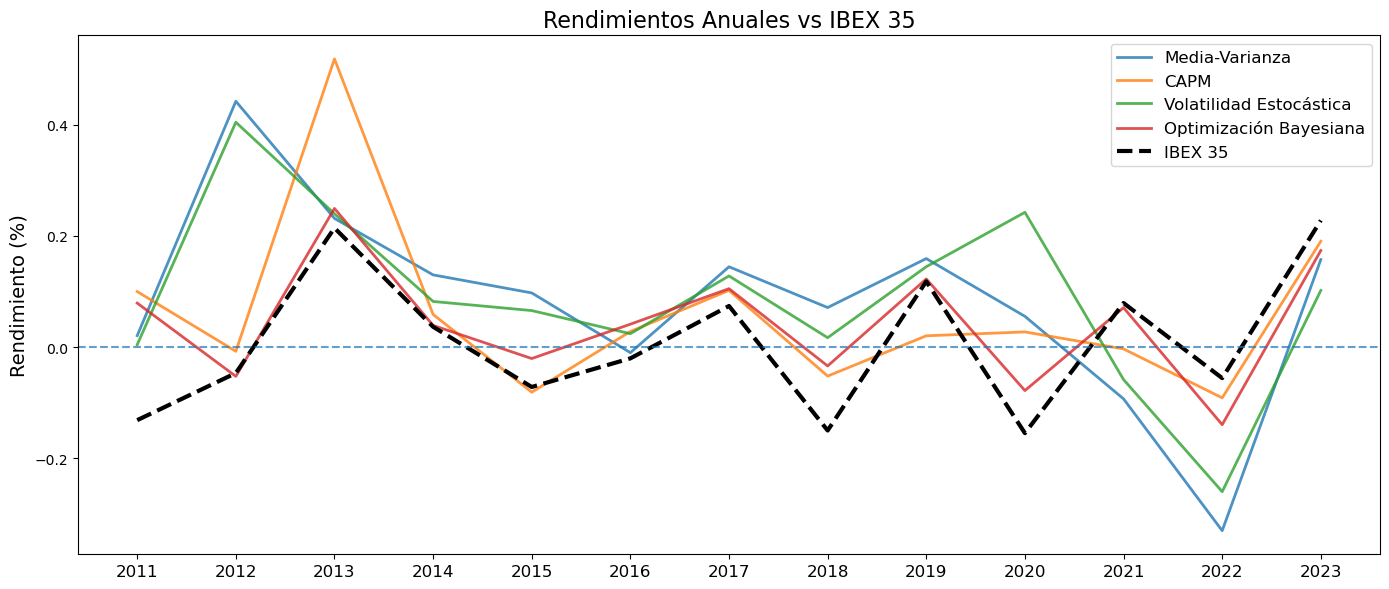

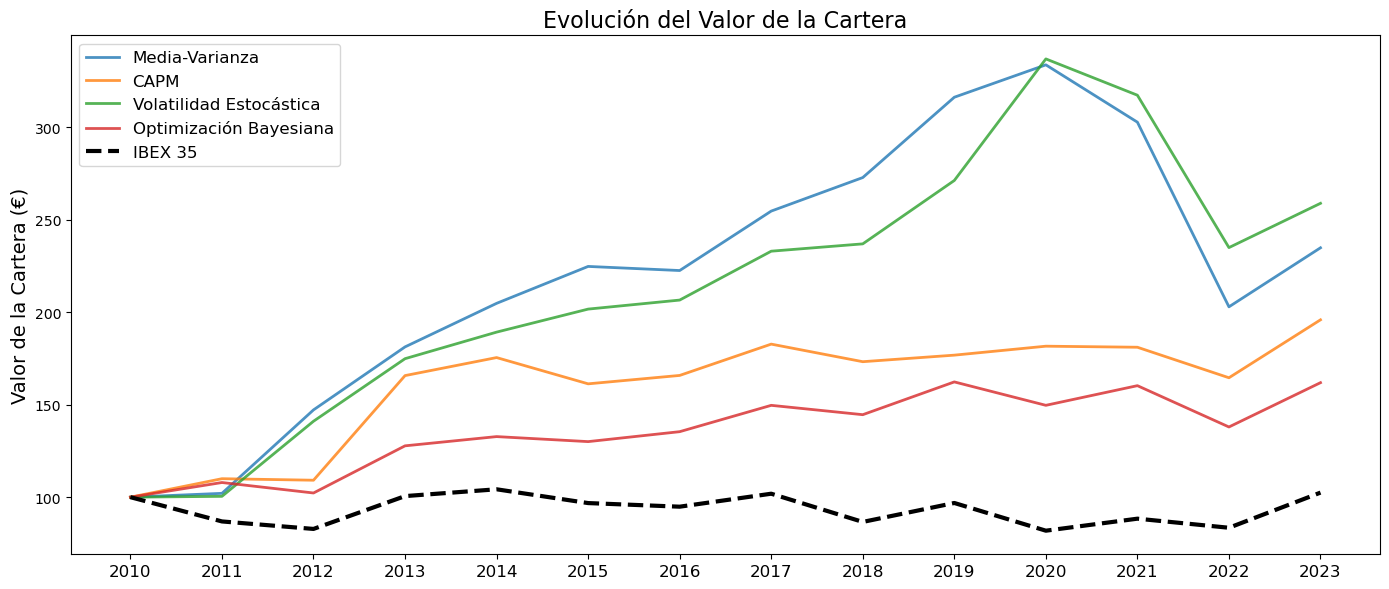

MMV              CAPM                 VE                OB  \
             Alfa  Δ Sharpe    Alfa  Δ Sharpe     Alfa  Δ Sharpe    Alfa   
2011       15.18% -0.087941  23.10%  3.363665   13.56% -1.082756  21.03%   
2012       48.83%  1.455108   3.91%  0.206419   45.06%  1.258310  -0.59%   
2013        1.71%  0.769137  30.37%  2.280538    2.54%  0.642326   3.50%   
2014        9.33% -0.549136   2.22%  0.249469    4.55% -1.094602   0.25%   
2015       16.90% -0.211275  -0.94% -0.182689   13.73% -0.531281   5.11%   
2016        1.02% -1.111182   4.83%  0.213546    4.43% -1.273218   6.14%   
2017        7.05%  1.428862   2.80%  1.440087    5.40%  0.683572   3.11%   
2018       22.09% -0.531201   9.78% -0.879069   16.67% -1.466632  11.60%   
2019        4.10%  0.211485  -9.78%  0.285871    2.64% -0.036543   0.44%   
2020       20.99% -0.845938  18.19%  0.290584   39.68% -0.467580   7.65%   
2021      -17.21% -2.929469  -8.25%  0.144869  -13.75% -2.942098  -0.83%   
2022      -27.41% -3.455901  -3.54% -0.348920  -20.40% -3.534959  -8.37%   
2023       -7.03% -0.329030  -3.73%  0.937923  -12.57% -0.965352  -5.40%   
Promedio    7.35% -0.475883   5.30%  0.615561    7.81% -0.831601   3.36%   

                    
          Δ Sharpe  
2011      2.155518  
2012     -0.041716  
2013      1.425810  
2014     -0.260202  
2015     -0.277210  
2016     -0.044171  
2017      1.324348  
2018     -1.217582  
2019      0.506859  
2020     -0.567738  
2021      1.180388  
2022     -1.518340  
2023      0.625432  
Promedio  0.253184

In [69]:
Ex_ante_3, Ex_post_3, Diferencias_3, Rendimientos_3, Pesos_3, Evolucion_3 = comparativa_modelos(año_inicio, años_atras, año_final)
visualizar_escenarios(Rendimientos_3, Evolucion_3)
Diferencias_3

In [70]:
Ex_ante_3

MMV                                CAPM                 \
     Rendimiento Esperado Sharpe Ex Ante Rendimiento Esperado Sharpe Ex Ante   
Año                                                                            
2011             20.6221%       0.624920              2.1982%      -0.074802   
2012              9.1717%       0.185710             -3.2625%      -0.288456   
2013             13.1349%       0.324903             -5.0299%      -0.334913   
2014             28.3199%       1.244557              4.9245%       0.004228   
2015             24.7111%       1.099836              0.4661%      -0.138838   
2016             24.2215%       1.081984              2.6228%      -0.040963   
2017             25.2085%       1.176412              4.2954%       0.047313   
2018             29.7289%       1.362203              6.0142%       0.184696   
2019             19.4562%       0.968691             -0.4852%      -0.120544   
2020             19.1829%       1.163095              0.3303%      -0.050778   
2021             36.4677%       1.500626             -0.4290%      -0.054225   
2022             38.7785%       1.963731              0.6337%      -0.009546   
2023             26.8283%       1.104062             -0.8868%      -0.080423   

                       VE                                  OB                 
     Rendimiento Esperado Sharpe Ex Ante Rendimiento Esperado Sharpe Ex Ante  
Año                                                                           
2011             20.3649%       0.963899              5.5342%       0.054352  
2012              8.9208%       0.231283             -2.5038%      -0.260186  
2013             13.5646%       0.469872             -4.9814%      -0.332372  
2014             28.3471%       1.478372             14.3696%       0.411315  
2015             23.3251%       1.139607              7.7283%       0.135721  
2016             26.2839%       1.424014             10.1263%       0.274136  
2017             28.3403%       1.571792             14.3997%       0.561983  
2018             27.7809%       1.638154             14.2193%       0.670147  
2019             19.3442%       1.054126              8.5529%       0.396646  
2020             20.0888%       1.283368              9.7072%       0.507744  
2021             38.9760%       2.206539             12.1428%       0.541312  
2022             42.4202%       2.484226             16.1313%       0.799571  
2023             26.2335%       1.426066              8.0714%       0.335952

In [71]:
Ex_post_3

MMV                            CAPM                 \
     Rendimiento Real Sharpe Ex Post Rendimiento Real Sharpe Ex Post   
Año                                                                    
2011          2.0704%       0.536979          9.9826%       3.288864   
2012         44.1771%       1.640818         -0.7450%      -0.082038   
2013         23.1271%       1.094040         51.7833%       1.945625   
2014         12.9860%       0.695421          5.8769%       0.253697   
2015          9.7451%       0.888561         -8.0897%      -0.321527   
2016         -0.9891%      -0.029198          2.8187%       0.172583   
2017         14.4424%       2.605274         10.2021%       1.487400   
2018          7.1149%       0.831001         -5.1956%      -0.694373   
2019         15.9148%       1.180177          2.0430%       0.165327   
2020          5.5375%       0.317157          2.7394%       0.239806   
2021         -9.2856%      -1.428843         -0.3179%       0.090644   
2022        -32.9709%      -1.492171         -9.1072%      -0.358467   
2023         15.7275%       0.775032         19.0272%       0.857500   

                   VE                              OB                 
     Rendimiento Real Sharpe Ex Post Rendimiento Real Sharpe Ex Post  
Año                                                                   
2011          0.4464%      -0.118857          7.9173%       2.209869  
2012         40.4074%       1.489593         -5.2441%      -0.301902  
2013         23.9605%       1.112199         24.9210%       1.093438  
2014          8.2124%       0.383770          3.9080%       0.151113  
2015          6.5731%       0.608326         -2.0435%      -0.141489  
2016          2.4191%       0.150796          4.1304%       0.229965  
2017         12.7929%       2.255364         10.5072%       1.886331  
2018          1.7003%       0.171521         -3.3758%      -0.547436  
2019         14.4556%       1.017584         12.2550%       0.903504  
2020         24.2272%       0.815788         -7.7970%      -0.059994  
2021         -5.8225%      -0.735559          7.0956%       1.721700  
2022        -25.9589%      -1.050733        -13.9293%      -0.718768  
2023         10.1875%       0.460714         17.3585%       0.961385

### Anexo: Pesos

#### Pesos Escenario 1

In [72]:
tabla_MMV = detalle_pesos(Pesos_1, 'MMV')

╭──────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ Ticker   │ 2011   │ 2012   │ 2013   │ 2014   │ 2015   │ 2016   │ 2017   │ 2018   │ 2019   │ 2020   │ 2021   │ 2022   │ 2023   │
├──────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ AENA     │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ 24.53% │ -      │ -      │ -      │
│ AMS      │ -      │ -      │ -      │ -      │ 28.67% │ 19.51% │ 51.50% │ 52.11% │ 23.67% │ 14.18% │ -      │ -      │ -      │
│ ANA      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ 21.82% │
│ BKT      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ 20.39% │ -      │ -      │ -      │ -      │ -      │
│ CIE      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ 43.91

In [73]:
tabla_CAPM = detalle_pesos(Pesos_1, 'CAPM')

╭──────────┬─────────┬─────────┬─────────┬────────┬─────────┬─────────┬────────┬────────┬─────────┬─────────┬─────────┬─────────┬─────────╮
│ Ticker   │ 2011    │ 2012    │ 2013    │ 2014   │ 2015    │ 2016    │ 2017   │ 2018   │ 2019    │ 2020    │ 2021    │ 2022    │ 2023    │
├──────────┼─────────┼─────────┼─────────┼────────┼─────────┼─────────┼────────┼────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ ABE      │ -       │ -       │ -       │ 3.00%  │ -       │ -       │ 3.18%  │ 3.39%  │ -       │ -       │ -       │ -       │ -       │
│ ABG.P    │ -       │ -       │ -       │ -      │ 100.00% │ -       │ -      │ -      │ -       │ -       │ -       │ -       │ -       │
│ ACS      │ -       │ -       │ -       │ 1.32%  │ -       │ -       │ 1.37%  │ 1.75%  │ -       │ -       │ -       │ -       │ -       │
│ AMS      │ -       │ -       │ -       │ -      │ -       │ -       │ 3.21%  │ 3.44%  │ -       │ -       │ -       │ -       │ -       │
│ ANA      │ -      

In [74]:
tabla_VE = detalle_pesos(Pesos_1, 'VE')

╭──────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ Ticker   │ 2011   │ 2012   │ 2013   │ 2014   │ 2015   │ 2016   │ 2017   │ 2018   │ 2019   │ 2020   │ 2021   │ 2022   │ 2023   │
├──────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ABE      │ -      │ -      │ -      │ 2.73%  │ -      │ -      │ -      │ 4.41%  │ -      │ -      │ -      │ -      │ -      │
│ ACS      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ 4.88%  │ -      │ -      │ -      │
│ AENA     │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ 22.51% │ -      │ -      │ -      │
│ AMS      │ -      │ -      │ -      │ -      │ 28.17% │ 4.59%  │ 22.50% │ 14.47% │ 7.79%  │ 5.72%  │ -      │ -      │ -      │
│ ANA      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -    

In [75]:
tabla_OB = detalle_pesos(Pesos_1, 'OB')

╭──────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ Ticker   │ 2011   │ 2012   │ 2013   │ 2014   │ 2015   │ 2016   │ 2017   │ 2018   │ 2019   │ 2020   │ 2021   │ 2022   │ 2023   │
├──────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ABG.P    │ 14.29% │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │
│ AENA     │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ 13.17% │ -      │ -      │ -      │
│ AMS      │ -      │ -      │ -      │ -      │ 25.00% │ 7.76%  │ 15.66% │ 19.91% │ 13.73% │ 13.17% │ -      │ -      │ -      │
│ ANA      │ -      │ -      │ -      │ -      │ -      │ 6.87%  │ -      │ -      │ 13.73% │ -      │ -      │ 16.67% │ 25.00% │
│ BKT      │ -      │ -      │ -      │ -      │ -      │ 7.76%  │ -      │ 19.91% │ -    

#### Pesos Escenario 2

In [76]:
tabla_MMV2 = detalle_pesos(Pesos_2, 'MMV')

╭──────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ Ticker   │ 2011   │ 2012   │ 2013   │ 2014   │ 2015   │ 2016   │ 2017   │ 2018   │ 2019   │ 2020   │ 2021   │ 2022   │ 2023   │
├──────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ABE      │ -      │ 2.18%  │ 5.00%  │ 5.00%  │ 6.72%  │ 5.00%  │ 2.88%  │ 6.38%  │ -      │ -      │ -      │ -      │ -      │
│ ABG.P    │ 5.43%  │ 5.00%  │ 3.09%  │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │
│ ACS      │ 4.62%  │ -      │ 3.76%  │ -      │ -      │ -      │ -      │ 2.39%  │ 1.82%  │ 1.05%  │ -      │ -      │ -      │
│ ACX      │ 5.21%  │ -      │ 2.27%  │ -      │ -      │ -      │ 2.42%  │ 2.97%  │ -      │ -      │ 2.98%  │ -      │ -      │
│ AENA     │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -    

In [77]:
tabla_CAPM2 = detalle_pesos(Pesos_2, 'CAPM')

╭──────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ Ticker   │ 2011   │ 2012   │ 2013   │ 2014   │ 2015   │ 2016   │ 2017   │ 2018   │ 2019   │ 2020   │ 2021   │ 2022   │ 2023   │
├──────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ABE      │ 2.32%  │ -      │ 8.77%  │ 3.30%  │ 3.26%  │ 5.00%  │ 3.72%  │ 3.84%  │ -      │ -      │ -      │ -      │ -      │
│ ABG.P    │ 5.22%  │ 4.29%  │ 8.86%  │ -      │ 10.00% │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │
│ ACS      │ 3.64%  │ -      │ 1.61%  │ 2.54%  │ 6.22%  │ 3.02%  │ 2.03%  │ 2.39%  │ 2.01%  │ 2.80%  │ -      │ -      │ -      │
│ ACX      │ 5.85%  │ 4.44%  │ 5.00%  │ -      │ -      │ 3.29%  │ -      │ -      │ 10.00% │ 5.39%  │ 1.93%  │ -      │ -      │
│ AENA     │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -    

In [78]:
tabla_VE2 = detalle_pesos(Pesos_2, 'VE')

╭──────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ Ticker   │ 2011   │ 2012   │ 2013   │ 2014   │ 2015   │ 2016   │ 2017   │ 2018   │ 2019   │ 2020   │ 2021   │ 2022   │ 2023   │
├──────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ABE      │ 3.23%  │ 3.55%  │ 4.86%  │ 4.89%  │ 7.91%  │ 6.60%  │ 5.00%  │ 5.00%  │ -      │ -      │ -      │ -      │ -      │
│ ABG.P    │ 5.00%  │ 5.06%  │ 4.74%  │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │
│ ACS      │ 5.00%  │ -      │ 2.31%  │ -      │ -      │ -      │ -      │ 4.60%  │ 6.10%  │ 5.06%  │ 6.77%  │ 5.00%  │ 5.00%  │
│ ACX      │ 5.01%  │ -      │ 4.27%  │ -      │ -      │ -      │ 2.02%  │ 2.00%  │ -      │ -      │ -      │ -      │ -      │
│ AENA     │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -    

In [79]:
tabla_OB2 = detalle_pesos(Pesos_2, 'OB')

╭──────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ Ticker   │ 2011   │ 2012   │ 2013   │ 2014   │ 2015   │ 2016   │ 2017   │ 2018   │ 2019   │ 2020   │ 2021   │ 2022   │ 2023   │
├──────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ABE      │ 3.05%  │ -      │ 3.75%  │ 3.44%  │ 3.01%  │ 4.25%  │ 2.83%  │ 4.87%  │ -      │ -      │ -      │ -      │ -      │
│ ABG.P    │ 6.07%  │ 1.07%  │ 4.81%  │ -      │ 1.10%  │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │
│ ACS      │ 4.08%  │ 5.80%  │ -      │ -      │ 4.73%  │ -      │ 5.85%  │ -      │ 2.62%  │ 3.80%  │ 4.85%  │ -      │ 3.66%  │
│ ACX      │ 1.69%  │ 3.29%  │ 5.47%  │ -      │ -      │ 1.95%  │ 2.82%  │ 4.83%  │ 1.76%  │ 4.82%  │ 4.57%  │ 1.94%  │ 3.44%  │
│ AENA     │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -    

#### Pesos Escenario 3

In [80]:
tabla_MMV3 = detalle_pesos(Pesos_3, 'MMV')

╭──────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ Ticker   │ 2011   │ 2012   │ 2013   │ 2014   │ 2015   │ 2016   │ 2017   │ 2018   │ 2019   │ 2020   │ 2021   │ 2022   │ 2023   │
├──────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ABE      │ -      │ -      │ 4.97%  │ 2.14%  │ -      │ -      │ -      │ 4.67%  │ -      │ -      │ -      │ -      │ -      │
│ ABG.P    │ 4.77%  │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │
│ ACS      │ 2.70%  │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │
│ AENA     │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ 22.60% │ 1.95%  │ -      │ -      │
│ AMS      │ -      │ -      │ -      │ -      │ 22.31% │ 18.96% │ 23.75% │ 24.14% │ 5.00%

In [81]:
tabla_CAPM3 = detalle_pesos(Pesos_3, 'CAPM')

╭──────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ Ticker   │ 2011   │ 2012   │ 2013   │ 2014   │ 2015   │ 2016   │ 2017   │ 2018   │ 2019   │ 2020   │ 2021   │ 2022   │ 2023   │
├──────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ABE      │ 1.41%  │ 2.57%  │ 5.00%  │ 3.20%  │ 2.10%  │ 4.89%  │ 3.50%  │ 3.77%  │ -      │ -      │ -      │ -      │ -      │
│ ABG.P    │ 6.09%  │ -      │ 5.00%  │ -      │ 25.00% │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │
│ ACS      │ 2.82%  │ 4.09%  │ 3.84%  │ 2.06%  │ 3.50%  │ -      │ 1.47%  │ 1.79%  │ -      │ 1.09%  │ -      │ -      │ -      │
│ ACX      │ 5.00%  │ 2.83%  │ 1.68%  │ -      │ -      │ 5.00%  │ -      │ -      │ 6.94%  │ 8.90%  │ 2.51%  │ 2.52%  │ -      │
│ AENA     │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -    

In [82]:
tabla_VE3 = detalle_pesos(Pesos_3, 'VE')

╭──────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ Ticker   │ 2011   │ 2012   │ 2013   │ 2014   │ 2015   │ 2016   │ 2017   │ 2018   │ 2019   │ 2020   │ 2021   │ 2022   │ 2023   │
├──────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ABE      │ -      │ -      │ 5.00%  │ 5.00%  │ 4.71%  │ 5.09%  │ 4.86%  │ 8.96%  │ -      │ -      │ -      │ -      │ -      │
│ ABG.P    │ 8.39%  │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │
│ ACS      │ 5.00%  │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ 5.00%  │ 7.68%  │ 5.00%  │ -      │ 5.00%  │
│ AENA     │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ 14.35% │ 2.30%  │ -      │ -      │
│ AMS      │ -      │ -      │ -      │ -      │ 20.89% │ 5.00%  │ 14.10% │ 11.89% │ 6.36%

In [83]:
tabla_OB3 = detalle_pesos(Pesos_3, 'OB')

╭──────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ Ticker   │ 2011   │ 2012   │ 2013   │ 2014   │ 2015   │ 2016   │ 2017   │ 2018   │ 2019   │ 2020   │ 2021   │ 2022   │ 2023   │
├──────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ ABE      │ 3.05%  │ 2.46%  │ 2.35%  │ 3.44%  │ 1.97%  │ 3.41%  │ 6.54%  │ 4.87%  │ -      │ -      │ -      │ -      │ -      │
│ ABG.P    │ 6.07%  │ 4.30%  │ 5.28%  │ -      │ 1.17%  │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │
│ ACS      │ 4.08%  │ 1.86%  │ 4.58%  │ -      │ 1.52%  │ 5.84%  │ 3.93%  │ -      │ 3.61%  │ 4.45%  │ 2.32%  │ 3.31%  │ 3.66%  │
│ ACX      │ 1.69%  │ 4.58%  │ 4.36%  │ -      │ -      │ 1.83%  │ 2.81%  │ 4.83%  │ -      │ 3.22%  │ 5.47%  │ 5.31%  │ 3.44%  │
│ AENA     │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -      │ -    